# Project 4

### Web Scraping Job Postings
<font color='blue'>
---

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score,accuracy_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 1. QUESTION 1: Factors that impact salary
---
<font color='blue'>
To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models


Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### 1.0 Import and clean the data.

In [2]:
# Load the data
# datafile = './jobsall.csv'
datafile = './jobs_new.csv'
jobs = pd.read_csv(datafile)

In [3]:
jobs.shape

(5648, 17)

In [4]:
jobs.head(2)

,link,location,scheme,company,job_title,address,employment_type,seniority,job_categories,salary,sal_type,num_of_applications,last_posted_date,expiry_date,company_info,job_desc,job_req
0,https://www.mycareersfuture.sg/job/data-engine...,South,NaN,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,"GRANDE BUILDING, 8 COMMONWEALTH LANE 149555",Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,MoneySmart.sg started life as a mortgage compa...,Mission As part of becoming one of the members...,Competencies Degree in Computer Science or an...
1,https://www.mycareersfuture.sg/job/data-scient...,South,Government support available,PORTCAST PTE. LTD.,Data Scientist,32 CARPENTER STREET 059911,Full Time,Middle Management,Engineering,"$2,200to$6,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Portcast Pte Ltd. is an early stage technology...,"In this role, you will be responsible for anal...",● Comfortable working with large amounts of d...


In [5]:
# drop irrelevant columns - link, address, num_of_applications, last_posted_date, company_info
jobs.drop(['link', 'address', 'num_of_applications', 'last_posted_date', 'expiry_date'],axis =1, inplace=True)

In [6]:
# Drop all duplicate data
jobs = jobs.drop_duplicates()

In [7]:
jobs.shape

(4082, 12)

In [8]:
# look at null values
jobs.isnull().sum().sort_values(ascending = False)

scheme             1944
sal_type            476
company_info        473
job_req             155
location            148
seniority            73
job_desc             12
salary               12
job_categories       12
employment_type      12
job_title            12
company              12
dtype: int64

In [9]:
# Examine the 'scheme' column
jobs['scheme'].value_counts(dropna= False)

Government support available    2138
NaN                             1944
Name: scheme, dtype: int64

In [10]:
# Convert 'scheme': {1: Government support available, 0: NaN}
jobs['scheme'] = jobs['scheme'].apply(lambda x: 1 if (x == 'Government support available') else 0 )

In [11]:
# Examine the 'salary' column
jobs['salary'].value_counts().head()

Salary undisclosed    464
$5,000to$7,000        108
$6,000to$8,000         86
$4,000to$6,000         67
$5,000to$8,000         65
Name: salary, dtype: int64

In [12]:
# Remove rows where 'salary' is undisclosed
jobs = jobs[~(jobs['salary']=='Salary undisclosed')]

In [13]:
# look at null values again
jobs.isnull().sum().sort_values(ascending = False)

company_info       404
job_req             72
location            63
seniority           19
job_desc            12
sal_type            12
salary              12
job_categories      12
employment_type     12
job_title           12
company             12
scheme               0
dtype: int64

In [14]:
# Drop all rows where there are missing values in any of the columns
# We have enough data to work with
jobs.dropna(how='any', inplace =True)
jobs.shape

(3152, 12)

In [15]:
# Look at the 'salary' data
jobs['salary'].head()

0     $5,000to$7,000
1     $2,200to$6,000
2     $3,500to$4,500
4    $9,000to$12,000
5    $5,000to$10,000
Name: salary, dtype: object

In [16]:
# Extract lower, upper and mean salary
jobs['salary'] = jobs['salary'].apply(lambda x: str(x).replace('$',''))
jobs['sal_lower'] = jobs['salary'].apply(lambda x: float(x.split("to")[0].replace(',','')))
jobs['sal_upper'] = jobs['salary'].apply(lambda x: float(x.split("to")[1].replace(',','')))

In [17]:
jobs['sal_type'].value_counts()

Monthly     3049
Annually     103
Name: sal_type, dtype: int64

In [18]:
# Salary specified could be monthly or annually.
# Standardize all salary to monthly salary. 
# Annual salary = 13 x monthly salary. Assume 12 x calendar mths+1 mth (AWS).
jobs['monthly'] = round((jobs['sal_lower'] + jobs['sal_upper'])/2)
jobs.loc[jobs.sal_type == 'Annually','monthly'] = round(jobs['monthly']/13)

# Drop these features since they are replaced.
jobs.drop(['salary', 'sal_type'],axis =1, inplace=True)

### 1.1 Examine 'monthly' salary

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


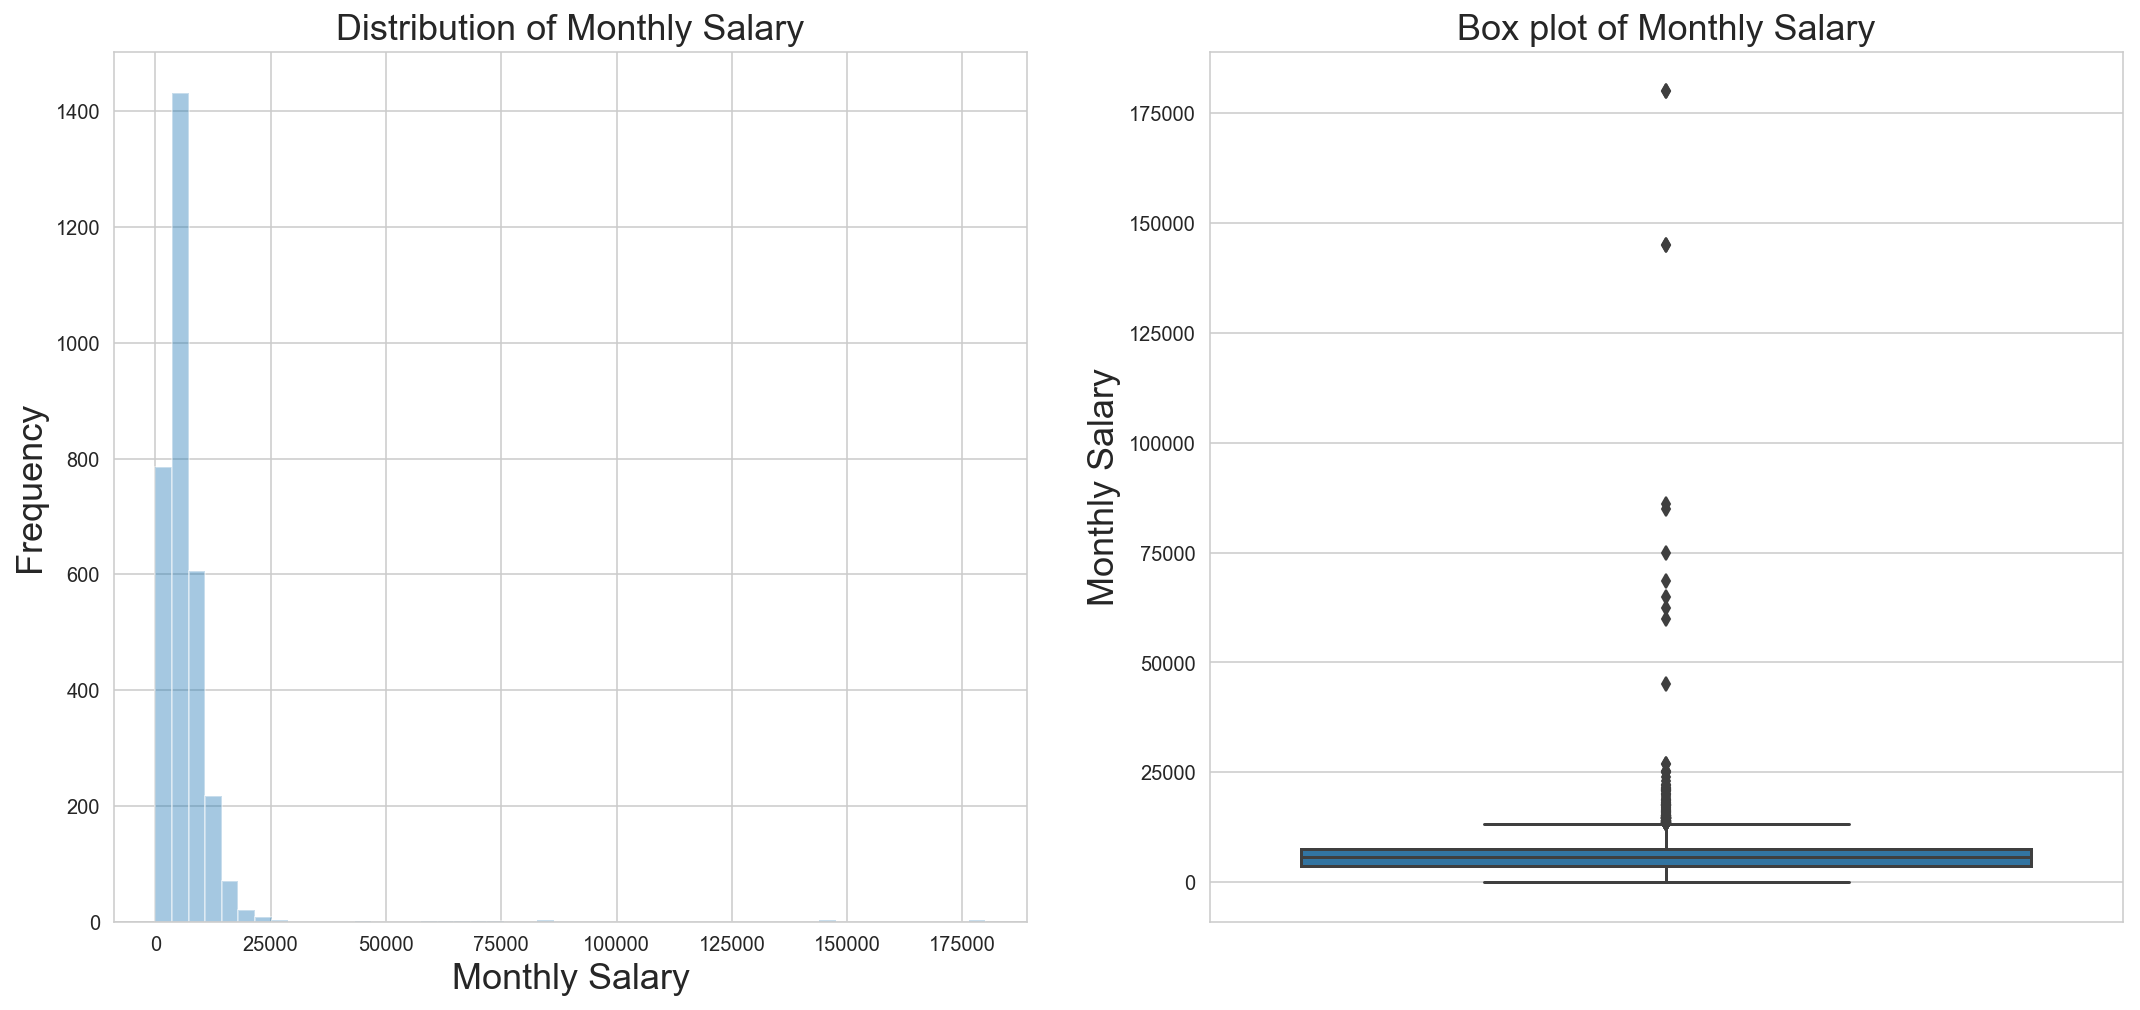

In [19]:
# Check out the monthly salary distribution and check for outliers
fig, axes = plt.subplots(ncols =2,figsize =(18,8))
ax0 = sns.distplot(jobs['monthly'],kde=False, ax=axes[0])
ax1 = sns.boxplot(y='monthly', data =jobs, ax=axes[1])

# Set plot title and x & y labels
ax0.set_title("Distribution of Monthly Salary", fontsize=18)
ax0.set_xlabel('Monthly Salary', fontsize=18)
ax0.set_ylabel('Frequency', fontsize=18)

ax1.set_title("Box plot of Monthly Salary", fontsize=18)
ax1.set_ylabel('Monthly Salary', fontsize=18)

plt.show()

In [20]:
# Look at rows with monthly salary > $30,000
jobs[jobs.monthly > 30000.0].sort_values(by='monthly', ascending = False)

,location,scheme,company,job_title,employment_type,seniority,job_categories,company_info,job_desc,job_req,sal_lower,sal_upper,monthly
1817,Central,1,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Head of SSO (APAC),Full Time,Middle Management,"Banking and Finance, Others",SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...,The SSO group provides business support servic...,Main Duties 1. A key positive aspect of the SI...,144000.0,216000.0,180000.0
3521,Central,0,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Head of SSO (APAC),Full Time,Middle Management,"Banking and Finance, Others",SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...,The SSO group provides business support servic...,Main Duties 1. A key positive aspect of the SI...,144000.0,216000.0,180000.0
1763,Central,1,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Senior Sales Manager,Full Time,Middle Management,Banking and Finance,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...,The new position is available in our Singapore...,Candidates should have a backgroud in selling ...,120000.0,170000.0,145000.0
3484,Central,0,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Senior Sales Manager,Full Time,Middle Management,"Banking and Finance, Others",SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.\...,The new position is available in our Singapore...,Candidates should have a backgroud in selling ...,120000.0,170000.0,145000.0
4055,Central,1,EXIGER SINGAPORE PTE. LTD.,Senior Data Scientist,"Permanent, Full Time",Professional,"Information Technology, Professional Services",Exiger is a global regulatory and financial cr...,Position Summary We are looking for a resource...,Professional Experience Required A degree in ...,12000.0,160000.0,86000.0
208,Islandwide,1,INC RESEARCH CRO SINGAPORE PTE. LTD.,SR Clinical Research Associate,"Permanent, Full Time","Professional, Executive, Senior Executive","Environment / Health , Healthcare / Pharmaceu...",INC Research is a top-tier therapeutically ...,The Senior Clinical Research Associate I (Sr C...,Requirements: BA/BS degree in science/health c...,80000.0,90000.0,85000.0
216,Islandwide,1,INC RESEARCH CRO SINGAPORE PTE. LTD.,SR Site Start-up & Regulatory Specialist,"Permanent, Full Time","Professional, Senior Executive","Environment / Health , Healthcare / Pharmaceu...",INC Research is a top-tier therapeutically ...,Performs assigned activities within the countr...,Requirements: BA/BS degree in the science/he...,70000.0,80000.0,75000.0
5256,East,0,VISA WORLDWIDE PTE. LIMITED,"New Grad, Senior Software Engineer (Master's D...",Full Time,Fresh/entry level,Information Technology,\r\n\tVISA WORLDWIDE PTE. LIMITED\r\n,"Common Purpose, Uncommon Opportunity. Everyone...","So what are we looking for in a New Grad, Soft...",57000.0,80000.0,68500.0
1323,Central,1,IHS MARKIT ASIA PTE. LTD.,"Senior Associate, Research and Analysis (Korea...","Permanent, Full Time",Senior Executive,Banking and Finance,\r\n\tMARKIT ASIA PTE. LTD.\r\n\r\n\tMarkit is...,Department overview: IHS Markit’s Dividend For...,Education and experience Undergraduate degr...,50000.0,80000.0,65000.0
3285,Central,1,DTCC DATA REPOSITORY (SINGAPORE) PTE. LTD.,Senior Business Systems Analyst,Full Time,Senior Executive,Information Technology,No information added.,Business Unit Description: AD Derivatives is r...,Qualifications Minimum of 8 years’ experience...,50000.0,75000.0,62500.0


In [21]:
# Except for the salary of the COO (index 986) which looks legitimate at 40,000 to 80,000 monthly, 
# the rest of above outliers could be due to:
# 1. The salary term (sal_type) should be Annual instead of Monthly / OR
# 2. The upper salary is entered wrongly with an extra trailing zero.
# We will fix them accordingly.

# Convert these to monthly salary  
jobs.loc[1817,'monthly'] = round(jobs.loc[1817,'monthly']/13)
jobs.loc[3521,'monthly'] = round(jobs.loc[3521,'monthly']/13)
jobs.loc[1763,'monthly'] = round(jobs.loc[1763,'monthly']/13)
jobs.loc[3484,'monthly'] = round(jobs.loc[3484,'monthly']/13)
jobs.loc[208,'monthly'] = round(jobs.loc[208,'monthly']/13)
jobs.loc[216,'monthly'] = round(jobs.loc[216,'monthly']/13)
jobs.loc[5256,'monthly'] = round(jobs.loc[5256,'monthly']/13)
jobs.loc[1323,'monthly'] = round(jobs.loc[1323,'monthly']/13)
jobs.loc[3285,'monthly'] = round(jobs.loc[3285,'monthly']/13)

# Fix the upper salary
jobs.loc[4055,'sal_upper'] = 16000
jobs.loc[4055,'monthly'] = round((jobs.loc[4055,'sal_lower'] + jobs.loc[4055,'sal_upper'])/2)

jobs.loc[1387,'sal_upper'] = 8500
jobs.loc[1387,'monthly'] = round((jobs.loc[1387,'sal_lower'] + jobs.loc[1387,'sal_upper'])/2)

# change 'monthly' salary to integer
jobs['monthly'] = jobs['monthly'].astype(int)

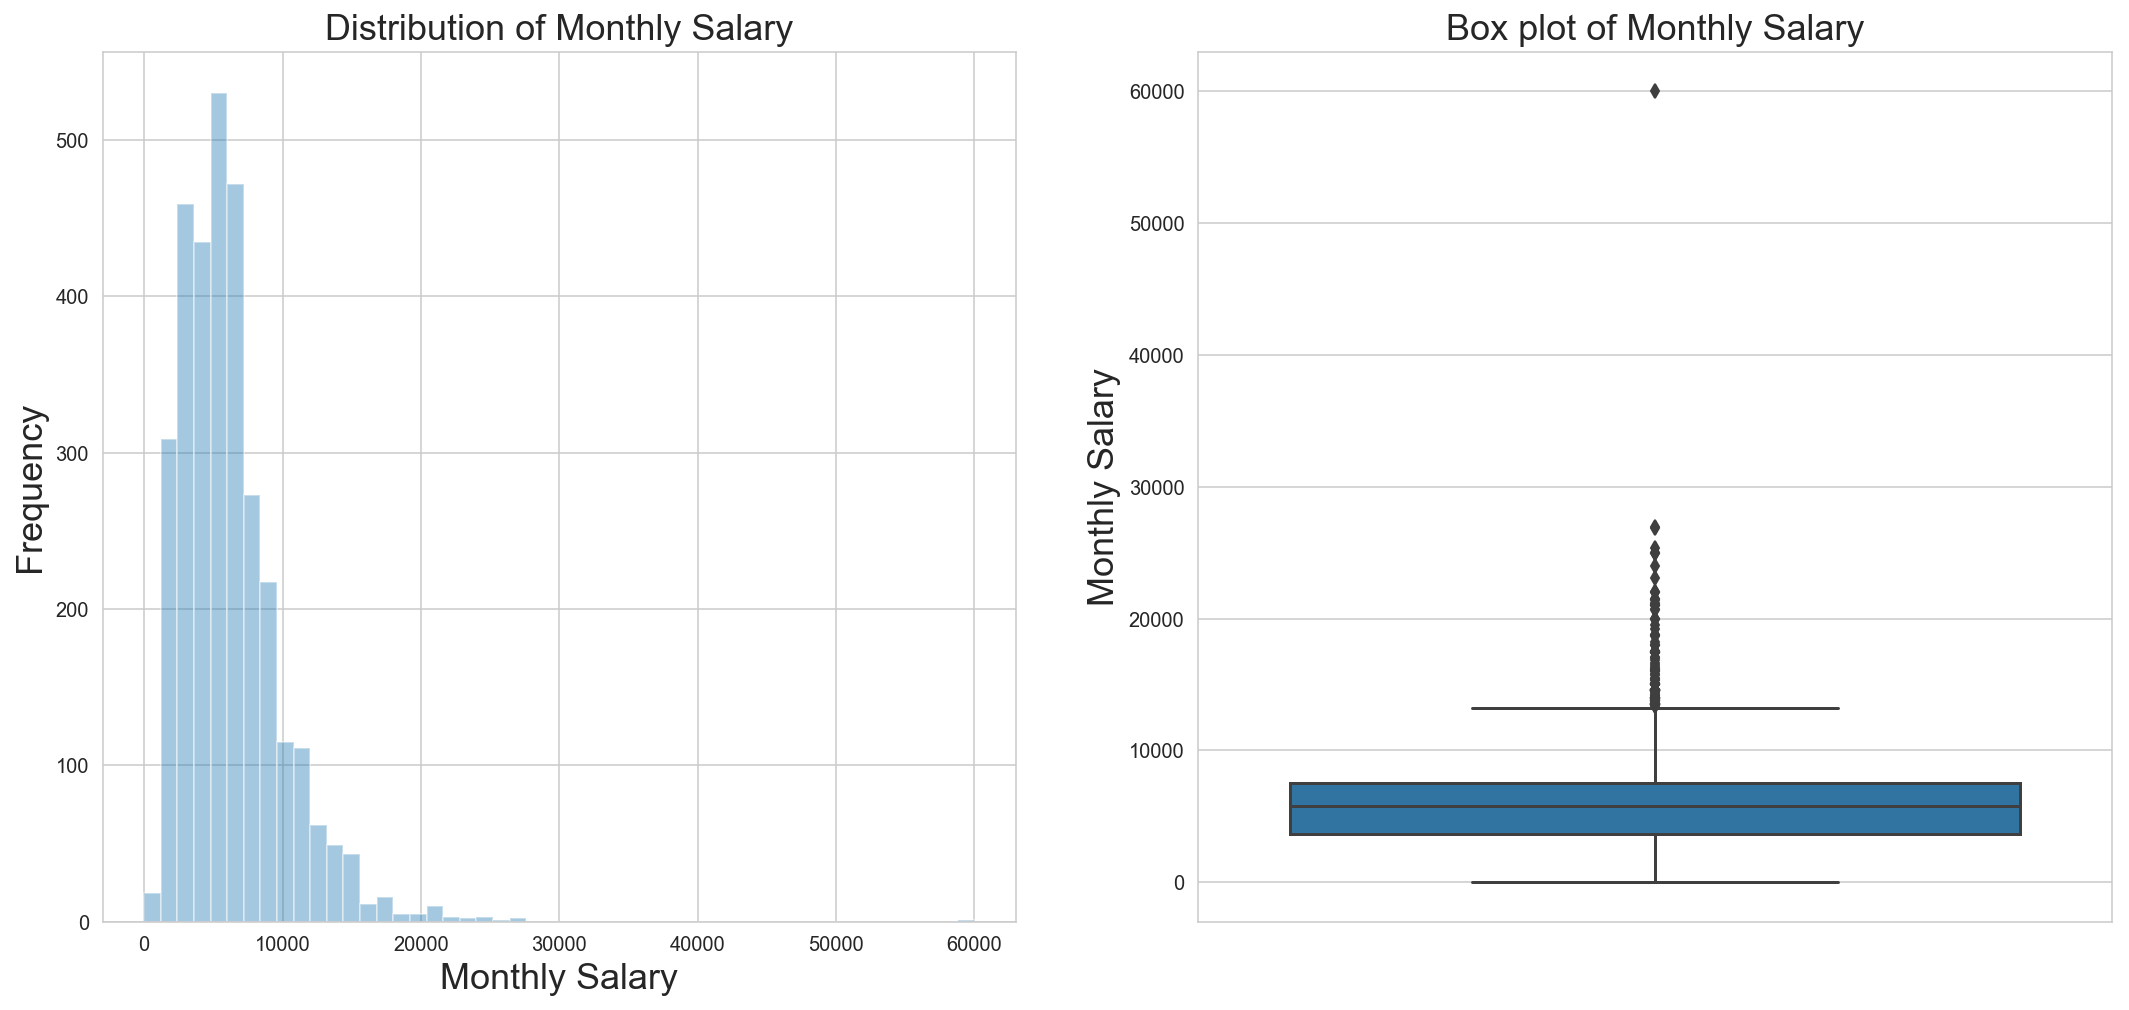

In [22]:
# Check out the 'monthly salary' distribution and check for outliers
fig, axes = plt.subplots(ncols =2,figsize =(18,8))
ax0 = sns.distplot(jobs['monthly'],kde=False, ax=axes[0])
ax1 = sns.boxplot(y='monthly', data =jobs, ax=axes[1])

# Set plot title and x & y labels
ax0.set_title("Distribution of Monthly Salary", fontsize=18)
ax0.set_xlabel('Monthly Salary', fontsize=18)
ax0.set_ylabel('Frequency', fontsize=18)

ax1.set_title("Box plot of Monthly Salary", fontsize=18)
ax1.set_ylabel('Monthly Salary', fontsize=18)

plt.show()

### 1.2 Examine the employment type

In [23]:
jobs['employment_type'].value_counts().head(12)

Full Time                         1127
Permanent                          671
Permanent, Full Time               576
Contract                           328
Contract, Full Time                276
Permanent, Contract                 32
Permanent, Contract, Full Time      30
Temporary                           24
Temporary, Contract                 23
Internship                          11
Part Time, Full Time                 8
Temporary, Contract, Full Time       8
Name: employment_type, dtype: int64

In [24]:
# Regroup the employment_type into main categories.
counts = jobs['employment_type'].value_counts()
mask =jobs['employment_type'].isin(counts[counts > 38].keys().values)
jobs.loc[~mask, 'employment_type'] = 'others'
jobs['employment_type'].value_counts()

Full Time               1127
Permanent                671
Permanent, Full Time     576
Contract                 328
Contract, Full Time      276
others                   174
Name: employment_type, dtype: int64

### 1.3 Re-group job titles

In [25]:
jobs['job_title'].value_counts().head(12)

Data Scientist        41
Accounts Executive    35
Data Engineer         29
Business Analyst      22
Research Fellow       22
Software Engineer     17
Accounts Assistant    17
Project Manager       15
Research Assistant    14
Accountant            14
Research Associate    12
Software Developer    12
Name: job_title, dtype: int64

In [26]:
jobs['job_title'].nunique()

2430

In [27]:
# We will re-group the job title into:
#'Data Scientist'
filtered_list = ['data scientist']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) )
jobs.loc[mask,'title'] = 'Data Scientist'

#'Data Analyst'
filtered_list = ['data analyst', 'data analytics', 'data consultant']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Data Analyst'

#'Data Engineer'
filtered_list = ['data engineer']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Data Engineer'

#'Business Intelligence'
filtered_list = ['business intelligence']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Business Intelligence'

# 'Database Engineer'
filtered_list = ['database admin', 'database dev']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Database Engineer'

# 'Big Data'
filtered_list = ['big data', 'hadoop']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Big Data'

#'Statistician'
filtered_list = ['statistician']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Statistician'

# 'Data-others'
filtered_list = ['data']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Data-Others'

# 'Analyst-others'
filtered_list = ['analyst']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Analyst-Others'

# 'Research-Others'
filtered_list = ['research']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Research-Others'

# 'Software-Others'
filtered_list = ['software']
mask = jobs['job_title'].map(lambda x: any(title in x.lower() for title in filtered_list) ) & jobs['title'].isnull()
jobs.loc[mask,'title'] = 'Software-Others'

In [28]:
jobs[jobs['title'].notnull()][['job_title', 'title']].shape

(952, 2)

In [29]:
# Drop the remaining rows as they are likely not relevant to data science field
jobs.dropna(axis=0,subset =['title'], inplace =True)
jobs.shape

(952, 14)

### 1.4 Regroup 'location' into 6 main locations:

In [30]:
jobs['location'].value_counts()

Central                        334
South                          221
East                           154
Islandwide                     121
West                            74
North                           23
East, Central                    7
South, Central                   5
South, East, Central             4
North, Central                   4
North, South, East, Central      1
East, West                       1
North, East                      1
North, West                      1
South, East                      1
Name: location, dtype: int64

In [31]:
jobs['location'] = jobs['location'].map(lambda x: 'East' if 'east' in x.lower() else x)
jobs['location'] = jobs['location'].map(lambda x: 'South' if 'south' in x.lower() else x)
jobs['location'] = jobs['location'].map(lambda x: 'North' if 'north' in x.lower() else x)

In [32]:
jobs['location'].value_counts().head(12)

Central       334
South         226
East          169
Islandwide    121
West           74
North          28
Name: location, dtype: int64

### 1.5 Regroup seniority

In [33]:
jobs['seniority'].value_counts()

Professional                                                   243
Executive                                                      202
Senior Executive                                               115
Non-executive                                                   92
Manager                                                         57
Junior Executive                                                43
Fresh/entry level                                               28
Middle Management                                               28
Senior Management                                               26
Professional, Non-executive                                     17
Executive, Senior Executive                                     14
Professional, Executive                                          9
Professional, Senior Executive                                   9
Manager, Senior Executive                                        7
Middle Management, Manager                                    

In [34]:
# Re-define adopting only the first appointment
jobs['seniority'] = jobs['seniority'].map(lambda x: x.split(',')[0])

In [35]:
jobs['seniority'].value_counts()

Professional         285
Executive            221
Senior Executive     115
Non-executive         93
Manager               77
Junior Executive      47
Fresh/entry level     45
Middle Management     39
Senior Management     30
Name: seniority, dtype: int64

In [36]:
jobs['job_categories'].value_counts().head(18)

Information Technology                                      426
Sciences / Laboratory / R&D                                 102
Banking and Finance                                          78
Others                                                       55
Engineering                                                  39
Consulting                                                   24
Engineering, Information Technology                          24
Engineering, Sciences / Laboratory / R&D                     18
Banking and Finance, Information Technology                  17
Healthcare / Pharmaceutical                                  12
Logistics / Supply Chain                                     10
Admin / Secretarial                                           9
Marketing / Public Relations                                  8
Consulting , Banking and Finance, Information Technology      7
Human Resources                                               7
Accounting / Auditing / Taxation        

In [37]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 5635
Data columns (total 14 columns):
location           952 non-null object
scheme             952 non-null int64
company            952 non-null object
job_title          952 non-null object
employment_type    952 non-null object
seniority          952 non-null object
job_categories     952 non-null object
company_info       952 non-null object
job_desc           952 non-null object
job_req            952 non-null object
sal_lower          952 non-null float64
sal_upper          952 non-null float64
monthly            952 non-null int32
title              952 non-null object
dtypes: float64(2), int32(1), int64(1), object(10)
memory usage: 107.8+ KB


### 1.6 Clean the Job description and Job requirements data

In [38]:
#combine Job description and Job requirements and clean the text

jobs['details'] = jobs['job_desc'] + jobs['job_req']
jobs.drop(['job_desc', 'job_req'],axis =1, inplace=True)

jobs['details'] = jobs['details'].map(lambda x:re.sub(r'[^\w\s\d]','', x.lower()))
jobs['details'] = jobs['details'].map(lambda x:re.sub(r'[\xa0]','', x.lower()))

In [39]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 5635
Data columns (total 13 columns):
location           952 non-null object
scheme             952 non-null int64
company            952 non-null object
job_title          952 non-null object
employment_type    952 non-null object
seniority          952 non-null object
job_categories     952 non-null object
company_info       952 non-null object
sal_lower          952 non-null float64
sal_upper          952 non-null float64
monthly            952 non-null int32
title              952 non-null object
details            952 non-null object
dtypes: float64(2), int32(1), int64(1), object(9)
memory usage: 100.4+ KB


### 2.0 Let's see how the factors affect the Monthly Salary

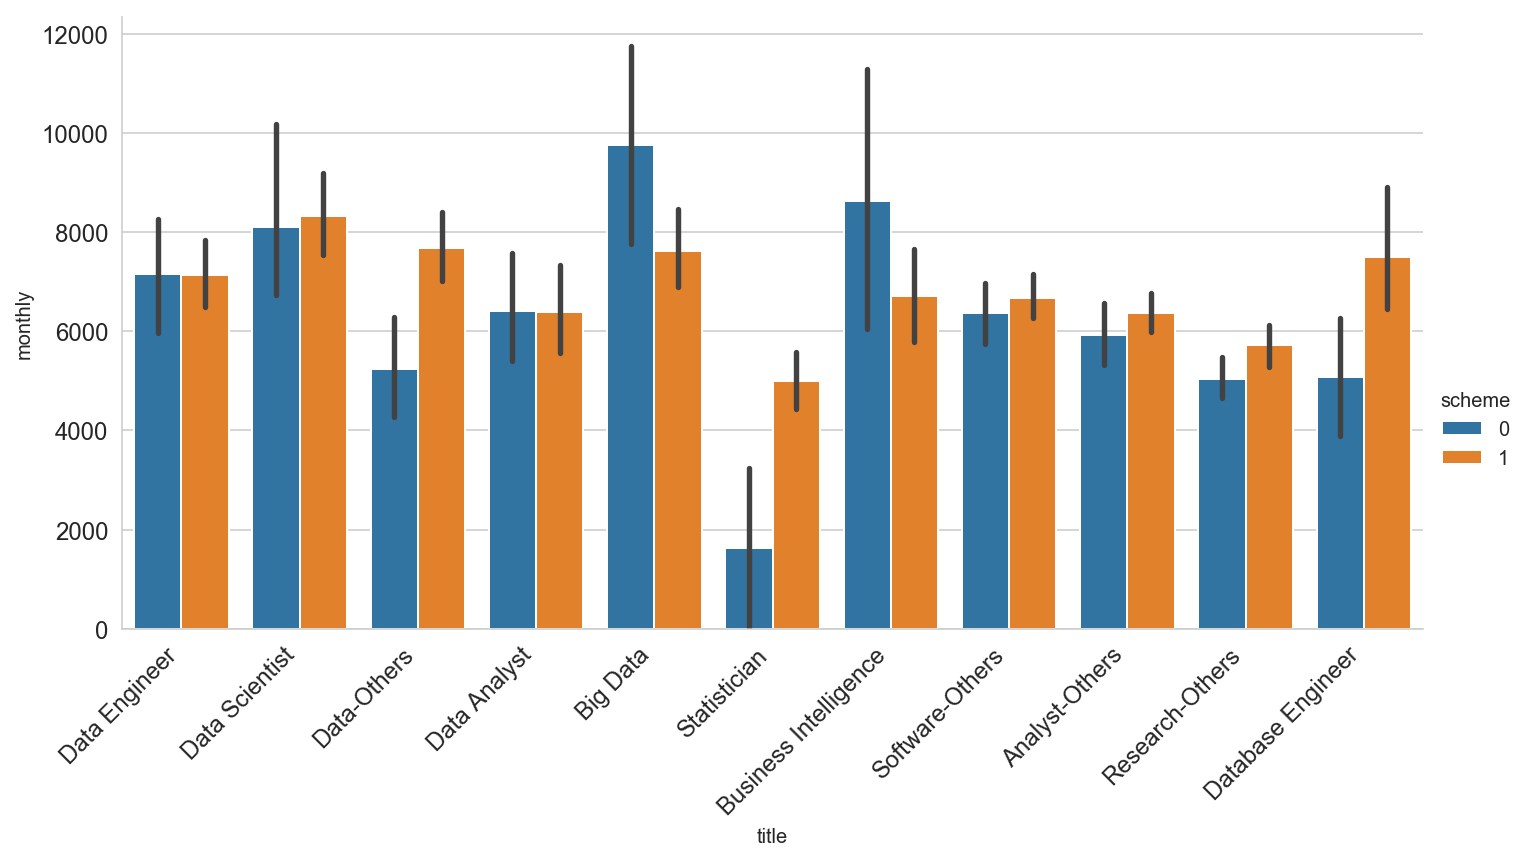

In [40]:
sns.catplot(x='title', y='monthly', data=jobs, kind='bar',hue='scheme', aspect=2) \
.set_xticklabels(rotation=45,fontsize=12, horizontalalignment='right') \
.set_yticklabels(fontsize=12)

# The mean pay of Data Scientist and Big Data engineer are generally
# higher. It seems that whether the scheme -governmentsupport available doesn't have
# any impact on the monthly pay. We will not use this data for any of our modelling.

In [41]:
np.round(jobs.groupby('title')[['monthly']].mean()).sort_values(by = 'monthly',ascending = False)

,monthly
title,
Data Scientist,8250.0
Big Data,7861.0
Business Intelligence,7162.0
Data Engineer,7136.0
Data-Others,6906.0
Software-Others,6575.0
Database Engineer,6456.0
Data Analyst,6393.0
Analyst-Others,6223.0


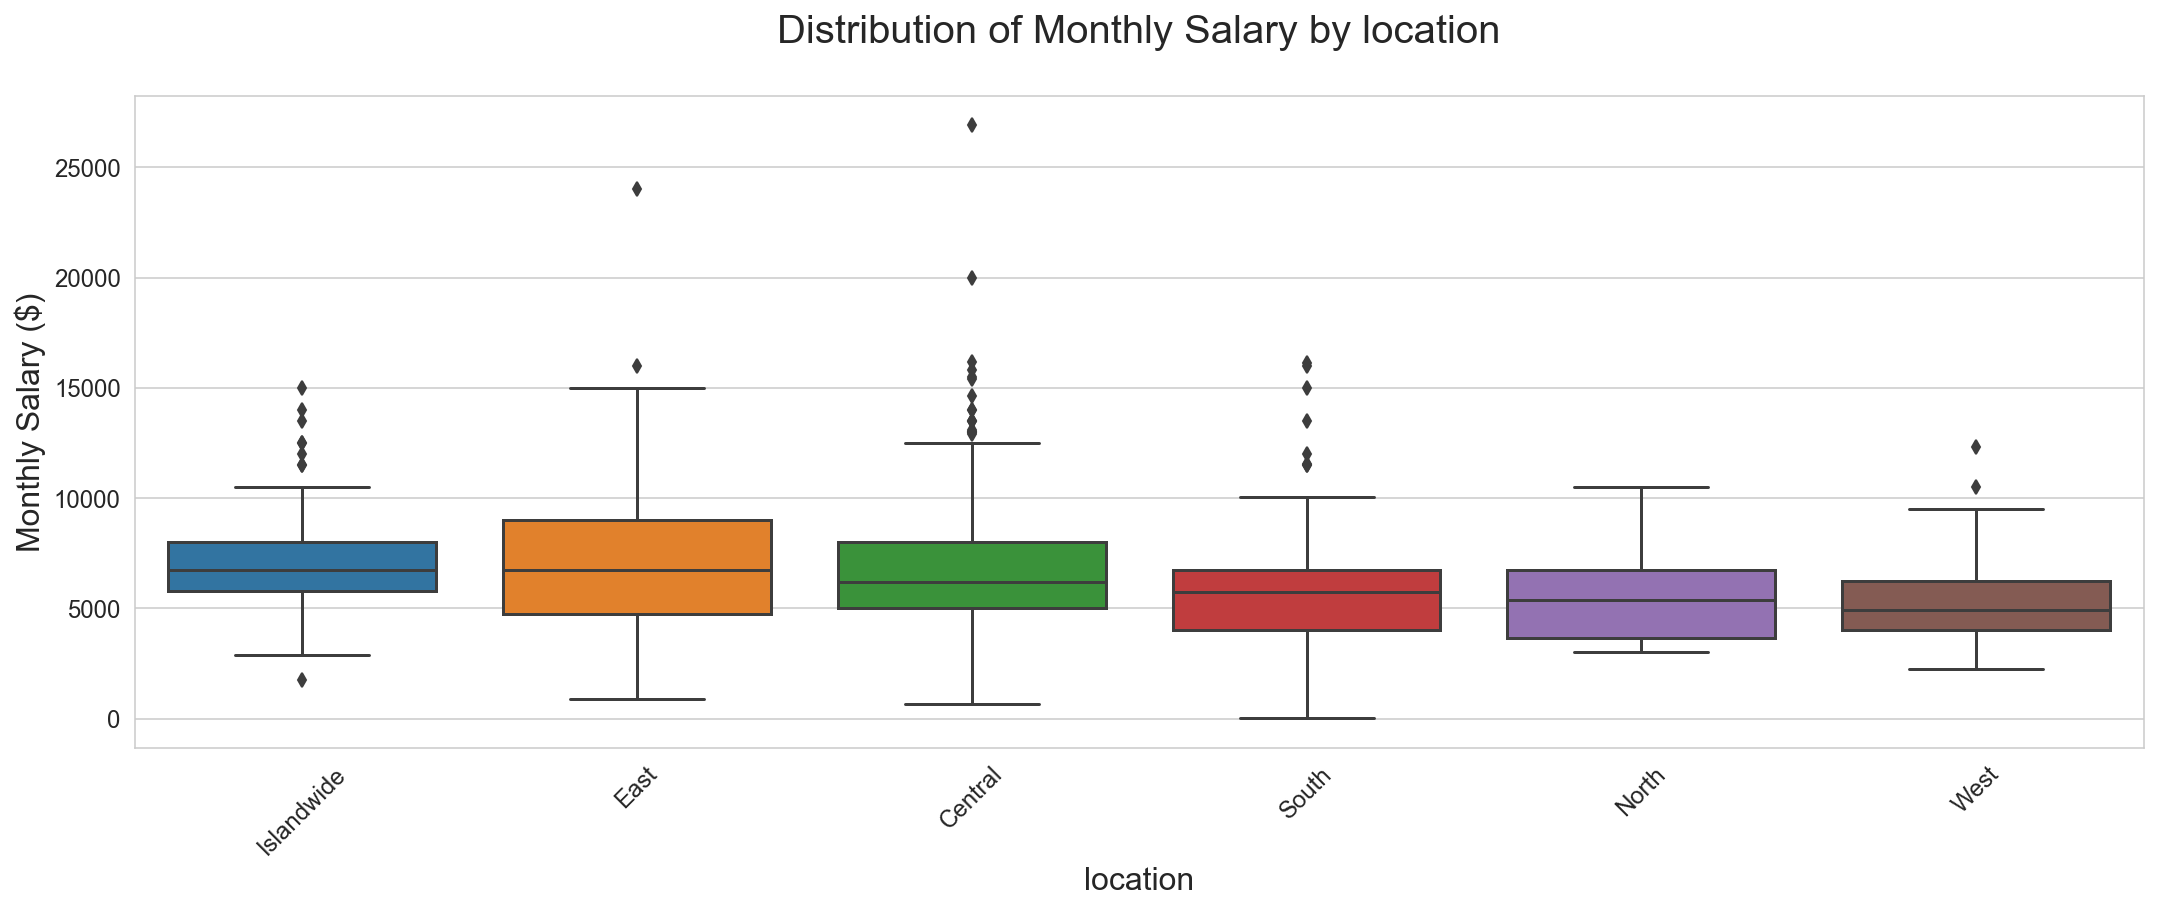

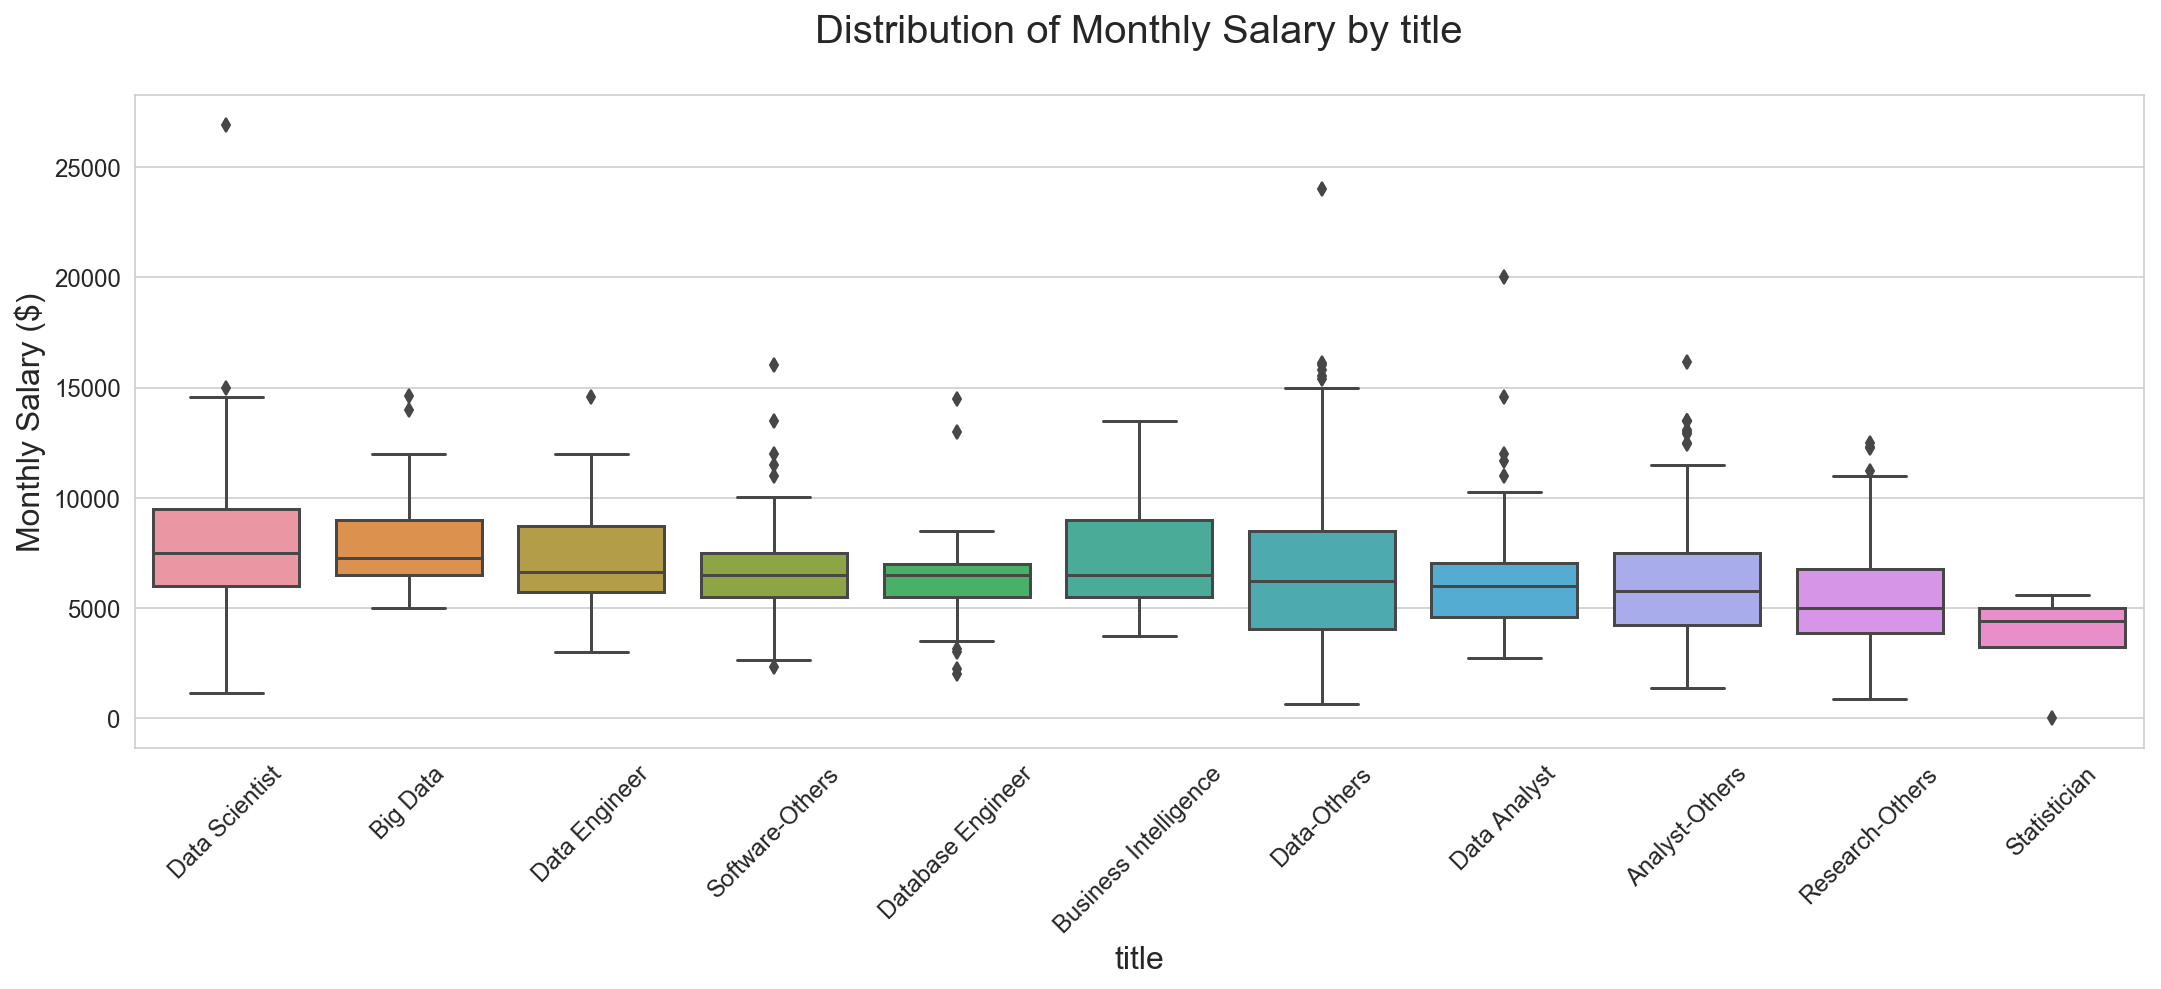

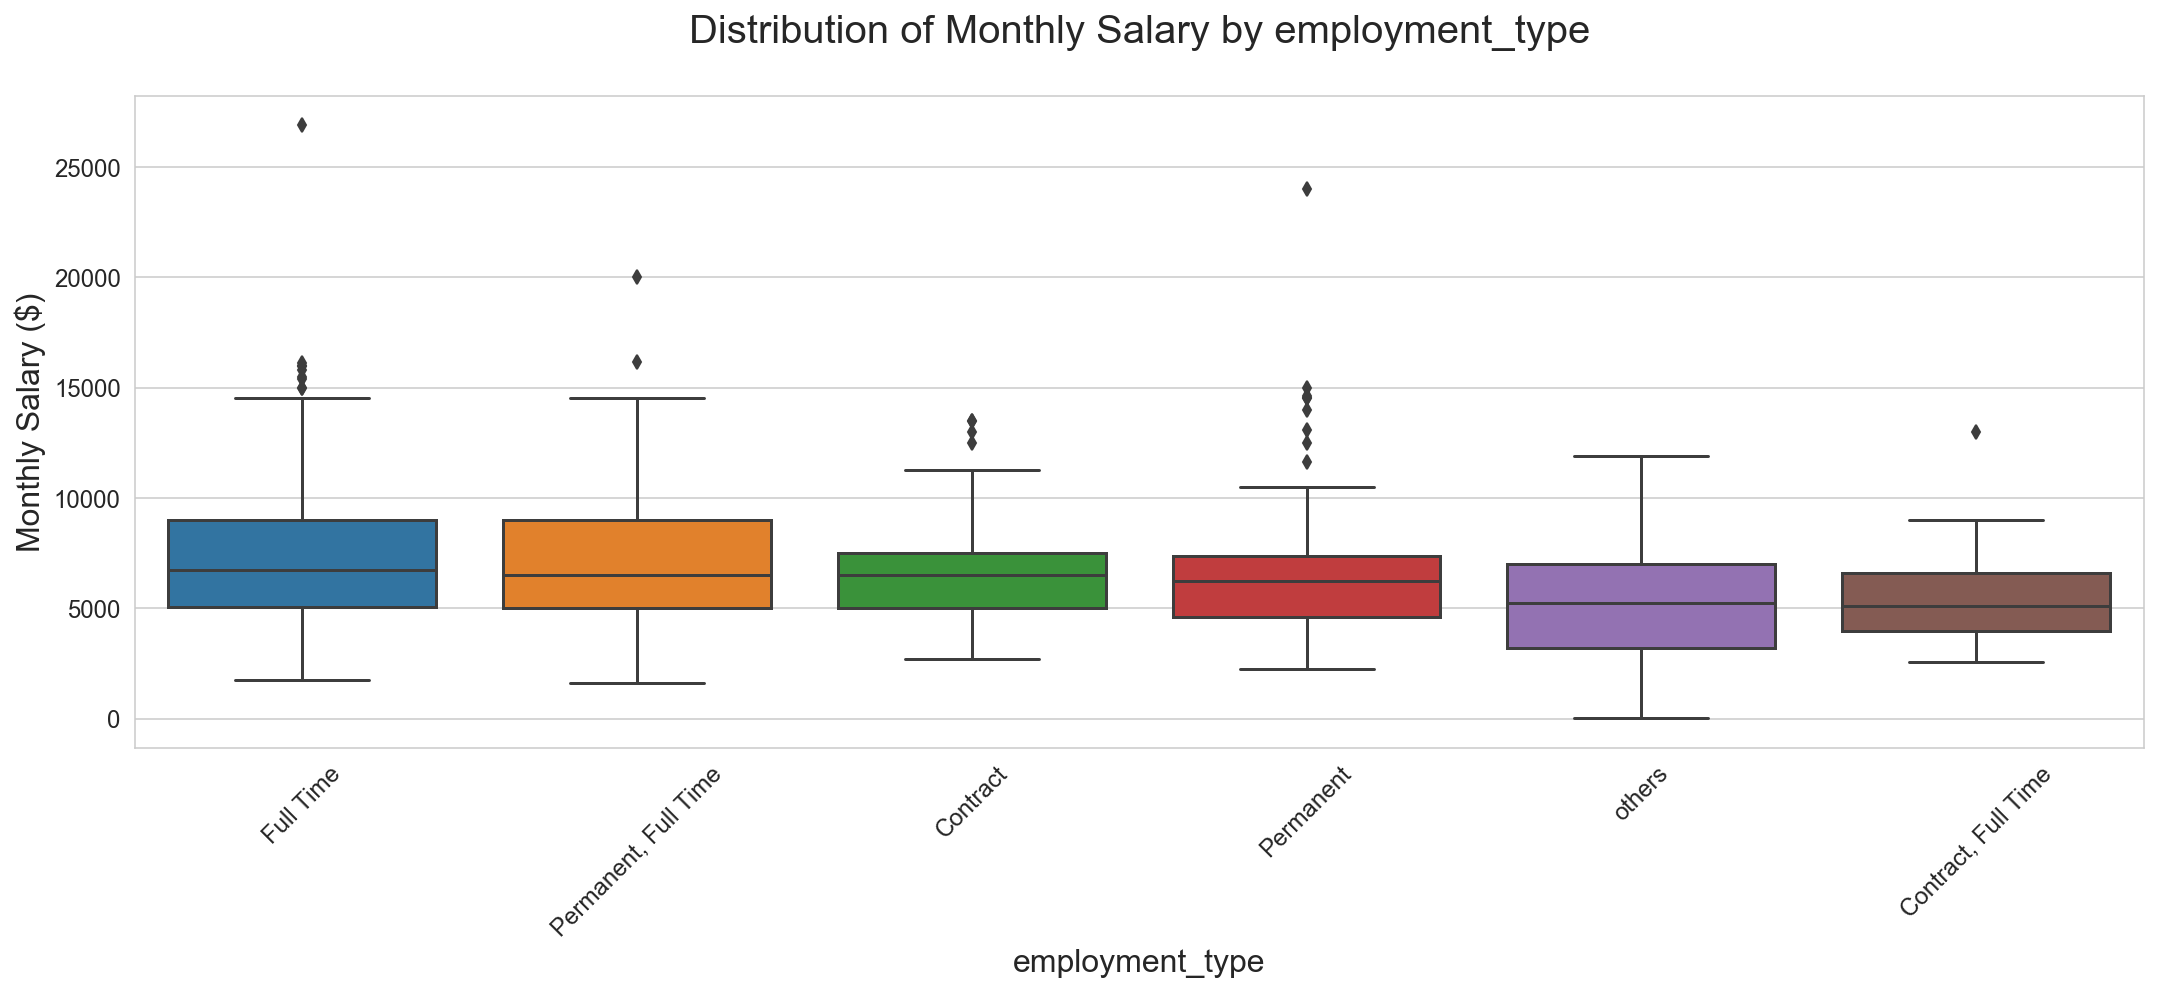

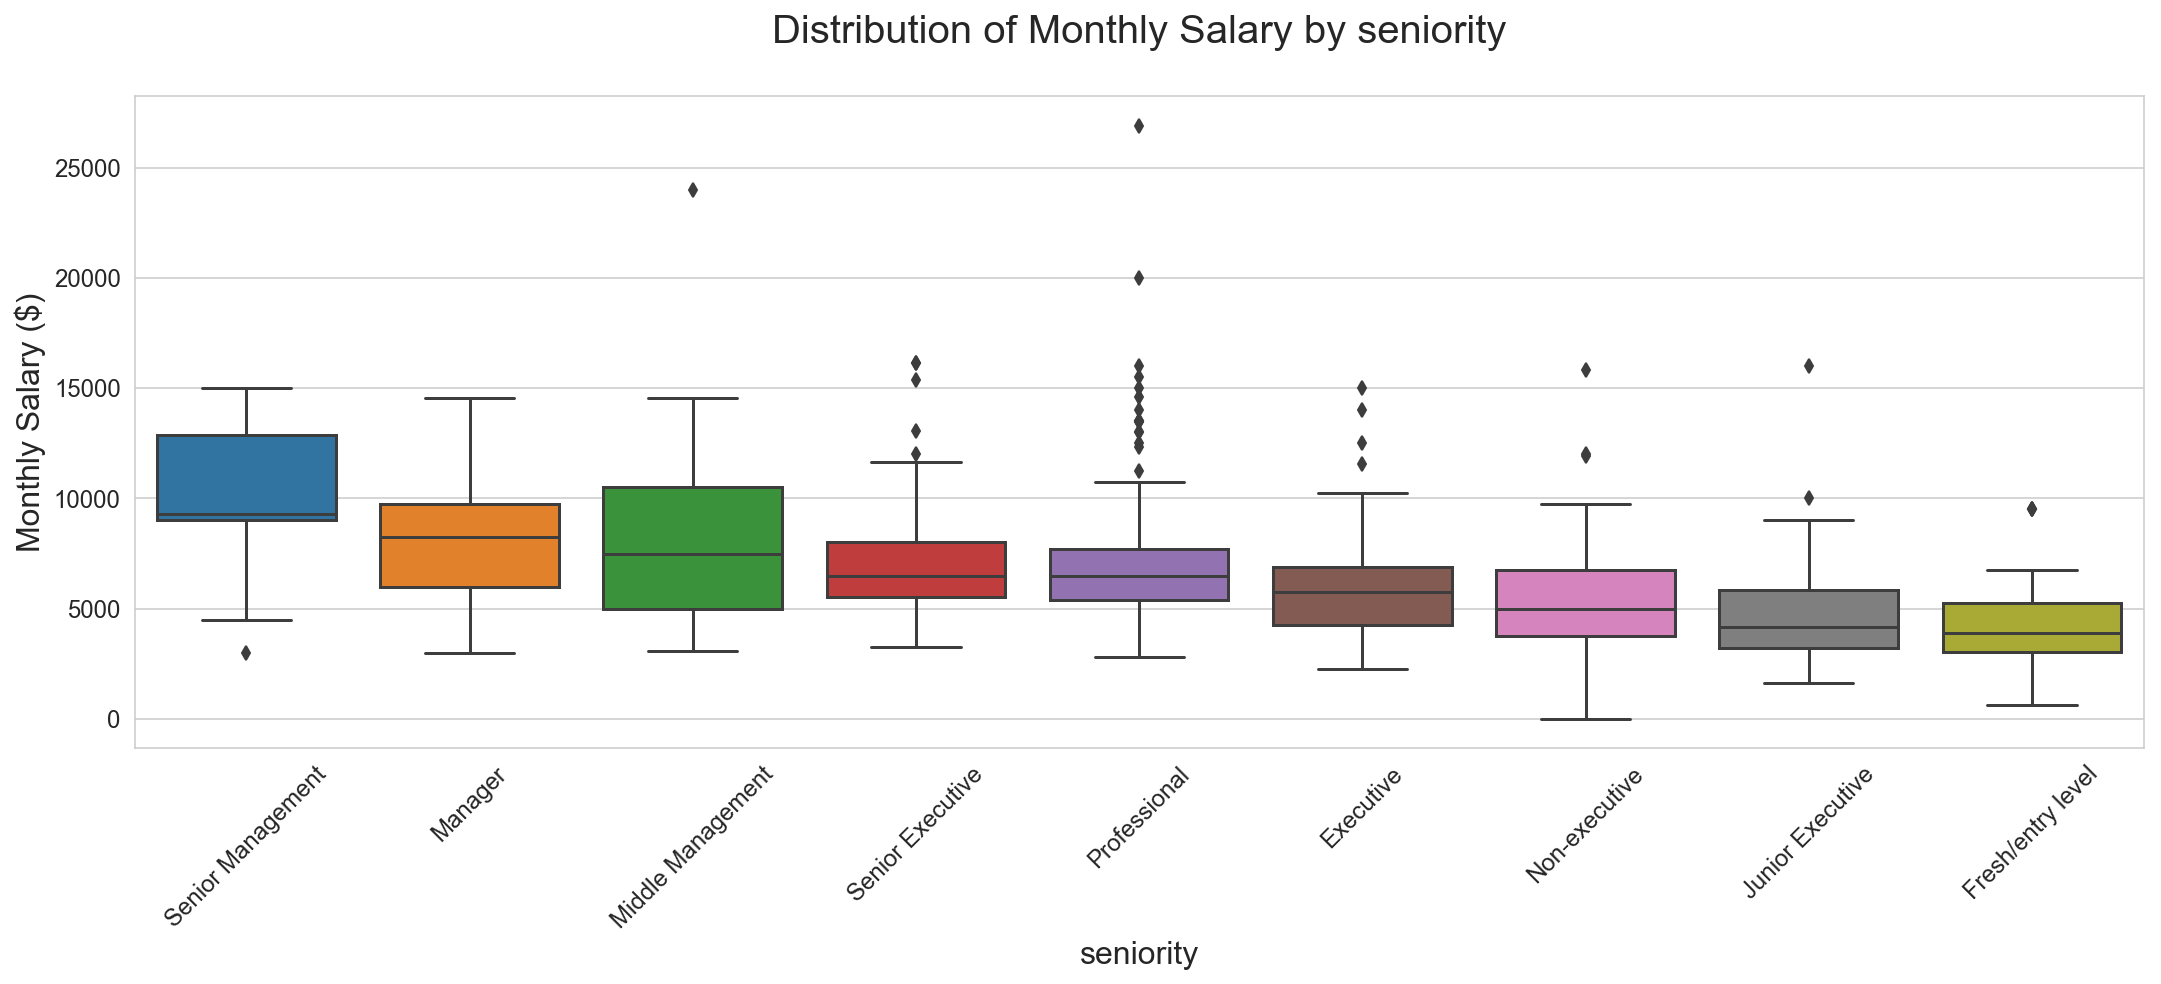

In [42]:
# Box plot to see correlation of following predictor to Monthly salary
predictors =['location','title','employment_type', 'seniority']

for col in predictors:
    fig, ax = plt.subplots(figsize=(18,6))
        
    order = jobs.groupby(by=col)['monthly'].median().sort_values(ascending=False).index
    ax = sns.boxplot(x = col, y='monthly', data = jobs, order = order, ax=ax)
    ax.set_ylabel('Monthly Salary ($)', fontsize=16)
    ax.set_xlabel(col, fontsize=16)

    plt.title('Distribution of Monthly Salary by {}\n'.format(col), fontsize =20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        tick.label.set_rotation(45)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    plt.show()
    

In [43]:
# Findings
# 1. Monthly Salary is higher in the East and Central than in the West
# 2. The median pay of Data Scientist is highest amongst all titles, 
#    however, the spread of the monthly Salary of a data scientist is also
#    the greatest.
# 3. Big Data engineers demands the highest minimum salary.
# 4. There are some outliers in the monthly pay for Data Analyst, 
#    some Data Analyst could be fetching the same pay scale as a Data Scientist.
# 5. Full time and Permanent/Full Time in general fetches a better salary.

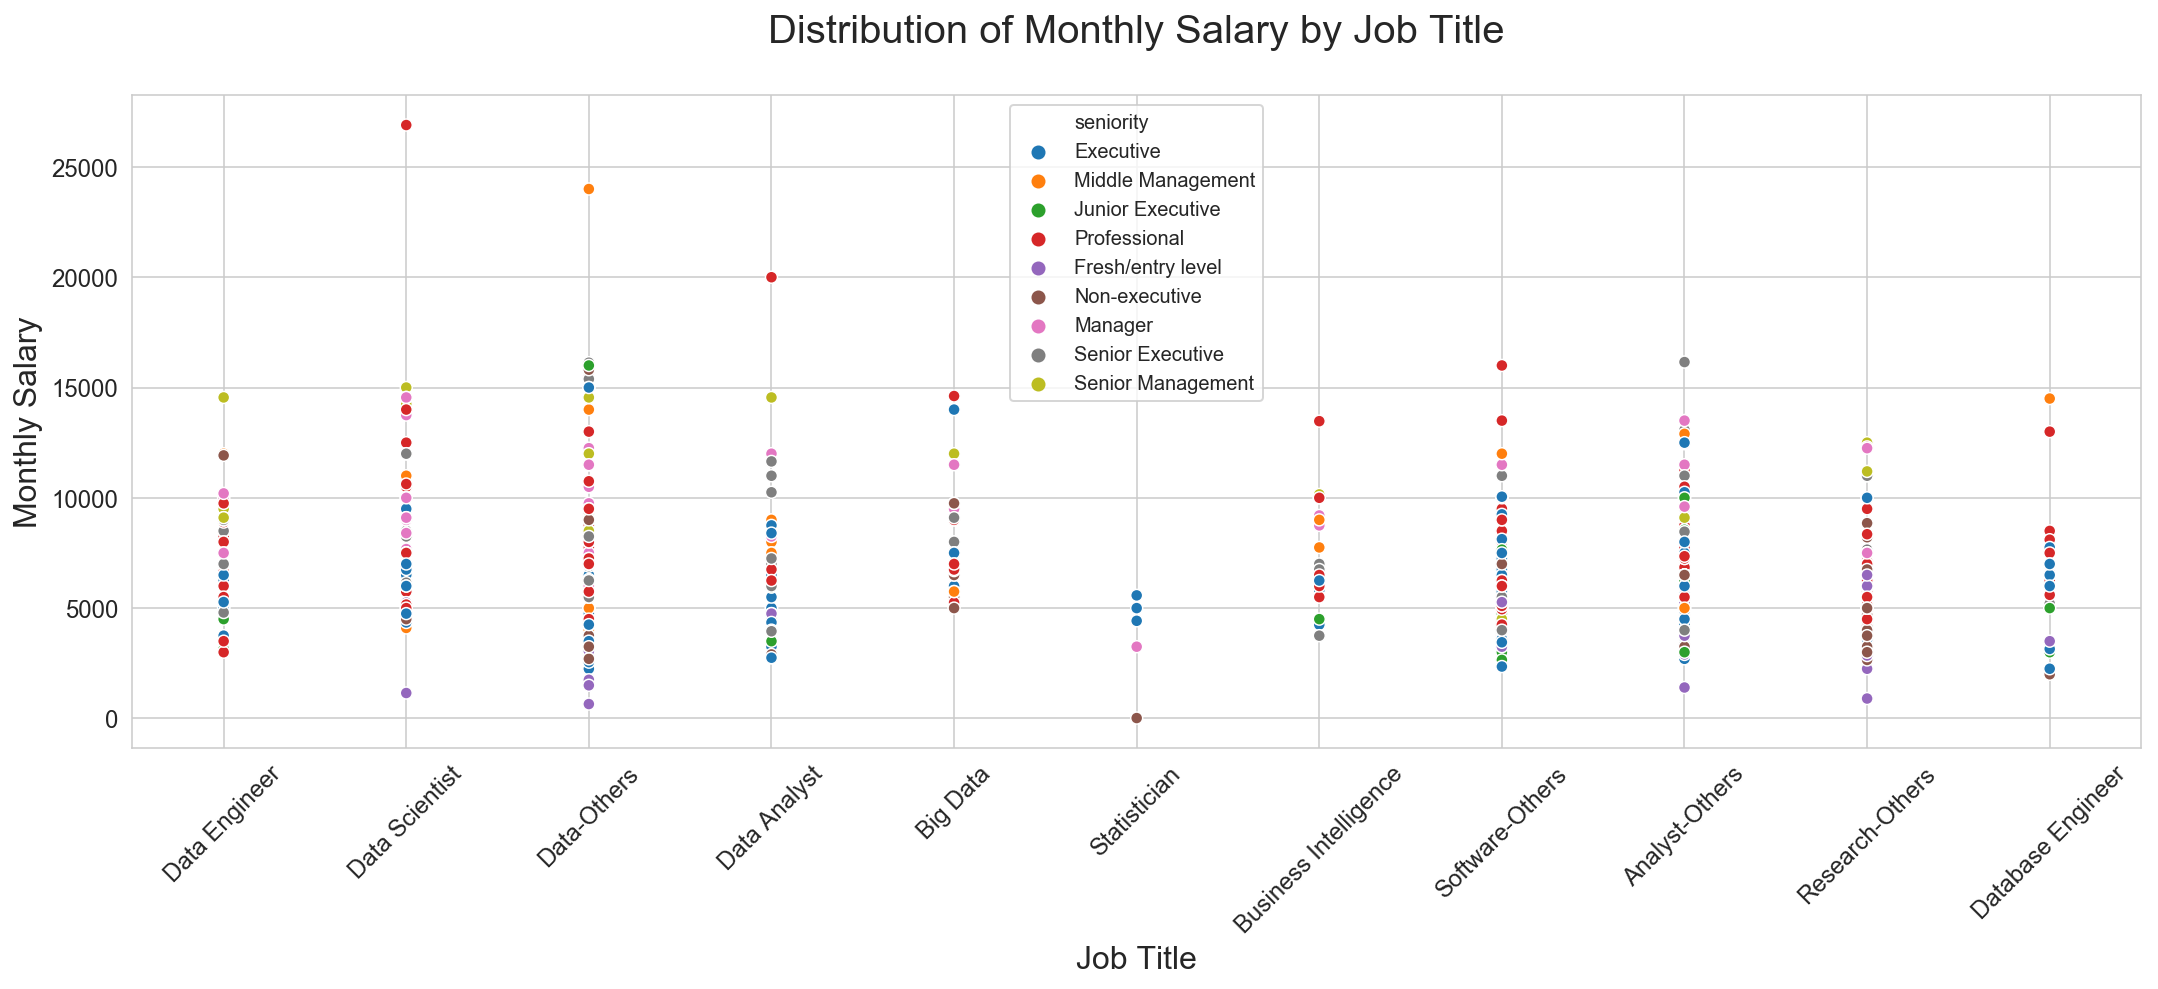

In [44]:
fig, ax = plt.subplots(figsize=(18,6))

ax = sns.scatterplot( x = 'title', y='monthly',hue ='seniority', data = jobs, ax=ax)
ax.set_xlabel('Job Title', fontsize=16)
ax.set_ylabel('Monthly Salary', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_rotation(45)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 

ax.set_title('Distribution of Monthly Salary by Job Title\n', fontsize =20)
plt.show()
# Data Scientist's salary can go low ($1150) for a Fresh/entry level to
# as high as $26,900 for Data Scientist in the information technology.
# On the other hand, Big Data engineer's monthly salary is less varied and
# with highest minimum salary in the industry.

In [45]:
print('Bottom 10 Data Scientist Monthly Salary: ')
jobs[jobs.title == "Data Scientist"][['monthly','job_title','job_categories','company']].sort_values(by = 'monthly', ascending = True).head(10)

Bottom 10 Data Scientist Monthly Salary: 


,monthly,job_title,job_categories,company
6,1150,Data Scientist - Intern (6 months),"Information Technology, Manufacturing, Others",JABIL CIRCUIT (SINGAPORE) PTE. LTD.
1,4100,Data Scientist,Engineering,PORTCAST PTE. LTD.
656,4350,Data Scientists,Information Technology,THATZ INTERNATIONAL PTE LTD
3664,4500,Junior Data Scientist,Information Technology,FIXED & MOBILE PTE. LTD.
652,4500,Data Scientist,"Information Technology, Manufacturing",JABIL CIRCUIT (SINGAPORE) PTE. LTD.
4062,4750,Data Scientist - Signal Processing,Information Technology,BIOFOURMIS SINGAPORE PTE. LTD.
1444,4750,Data Scientist,Information Technology,LYNX ANALYTICS PTE. LTD.
4059,5000,Data Scientist,Engineering,LAM RESEARCH SINGAPORE PTE LTD
3673,5000,Data Scientist - Signal Processing,Information Technology,BIOFOURMIS SINGAPORE PTE. LTD.
4056,5160,Data Scientist (Contract),"Engineering, Information Technology",KEYSIGHT TECHNOLOGIES SINGAPORE (SALES) PTE. LTD.


In [46]:
print('Top 10 Data Scientist Monthly Salary: ')
jobs[jobs.title == "Data Scientist"][['monthly','job_title','job_categories','company']].sort_values(by = 'monthly', ascending = False).head(10)

Top 10 Data Scientist Monthly Salary: 


,monthly,job_title,job_categories,company
396,26900,Data Scientist - Information Technology,Banking and Finance,NOMURA SINGAPORE LIMITED
3270,15000,"SVP, Data Scientist, Business Analytics, Consu...",Information Technology,DBS BANK LTD.
3269,14550,"VP, Data Scientist, Business Analytics, Consum...",Information Technology,DBS BANK LTD.
3271,14550,"VP, Senior Data Scientist, Regional Consumer B...",Banking and Finance,DBS BANK LTD.
3275,14550,"VP, Data Scientist, Investment and Trading Tec...",Banking and Finance,DBS BANK LTD.
2392,14250,"SVP / VP, Senior Data Scientist, Data & Transf...",Banking and Finance,DBS BANK LTD.
4055,14000,Senior Data Scientist,"Information Technology, Professional Services",EXIGER SINGAPORE PTE. LTD.
404,13750,Data Scientist,Banking and Finance,STANDARD CHARTERED BANK
2614,12500,Data Scientist,Information Technology,LEAP (G) PTE. LTD.
2870,12000,"Senior Manager, Data Scientist, Advisory",Information Technology,ERNST & YOUNG ADVISORY PTE. LTD.


In [47]:
# Data Scientist in the Banking and Finance generally fetches higher remuneration,
# while the pay in the Information Technology is more unpredictable.

### 3.0 Modelling

In [48]:
# We want to predict the salary using the following features : 
# location, title, employment_type, seniority and detailed description
# of the job.
# We will frame this as a classification problem.
# First, we label is_high_sal = 1 if monthly salary is greater than the
# median salary.

jobs_med = jobs['monthly'].median()
jobs_med

6237.5

In [49]:
jobs['is_high_sal'] = jobs['monthly'].apply(lambda x: True if (x> jobs_med) else False)

In [50]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 5635
Data columns (total 14 columns):
location           952 non-null object
scheme             952 non-null int64
company            952 non-null object
job_title          952 non-null object
employment_type    952 non-null object
seniority          952 non-null object
job_categories     952 non-null object
company_info       952 non-null object
sal_lower          952 non-null float64
sal_upper          952 non-null float64
monthly            952 non-null int32
title              952 non-null object
details            952 non-null object
is_high_sal        952 non-null bool
dtypes: bool(1), float64(2), int32(1), int64(1), object(9)
memory usage: 141.3+ KB


### 3.1 Train - Test Split

In [51]:
# Setup the Predictors and target
# Predictors: 'location','title','employment_type','seniority','job_categories','details'
# target : 'is_high_sal'

# One-hot encoding for all predictors except for details ('job_desc' & 'job_req')
X_dummy = pd.get_dummies(jobs[['location','title','employment_type',
                                'seniority','job_categories']],
                                       drop_first = True)
X = pd.concat([X_dummy, jobs[['details']]], axis=1)

y = jobs['is_high_sal']


In [52]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 8,
                                                    stratify =y)

In [53]:
# Transforming X_train
# Convert the 'details' feature to word tokens, ignore words 
# that only appeared once
cvec = CountVectorizer(stop_words='english', min_df=2, )
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['details']).todense(), 
                            columns=cvec.get_feature_names())

# Top 20 frequent words
X_train_cvec.sum(axis=0).sort_values(ascending=False)[:20]

data            3472
experience      2028
business        1304
work            1108
skills          1086
team            1053
management       879
knowledge        776
research         673
support          657
strong           652
development      644
analysis         619
design           586
ability          569
project          562
good             557
working          554
years            511
requirements     505
dtype: int64

In [54]:
# Concatenate X_train_cvec and with remaining features of X_train
X_train_trf = X_train.copy().reset_index(drop = True)
X_train_trf.drop(['details'],axis =1, inplace=True)
X_train_trf = pd.concat([X_train_trf, X_train_cvec], axis=1)

In [55]:
# Do the same transformation for X_test
# Vectorise the 'details' feature
X_test_cvec = pd.DataFrame(cvec.transform(X_test['details']).todense(), 
                            columns=cvec.get_feature_names())

# Concatenate X_train_cvec and with remaining features of X_train 
X_test_trf = X_test.copy().reset_index(drop = True)
X_test_trf.drop(['details'],axis =1, inplace=True)
X_test_trf = pd.concat([X_test_trf, X_test_cvec], axis=1)

In [56]:
X_train_trf.shape

(666, 5850)

In [57]:
X_test_trf.shape

(286, 5850)

### 3.2 PCA and LogisticRegression

In [58]:
# Transform the X predictros to new component variable matrix
pca = PCA(n_components=200)
X_train_pcs = pca.fit_transform(X_train_trf)

X_train_var_eigenvals = pca.explained_variance_
X_train_var_pct = pca.explained_variance_ratio_

# print('eigenvalues: {}'.format(np.round(X_train_var_eigenvals,2)))
# print('explained variance %: {}'.format(np.round(X_train_var_pct,2)))

In [59]:
csum =0
for i in range(1, len(X_train_var_pct)+1):
    csum = sum(X_train_var_pct[:i])
print(csum)
# We could still retain 84% of the variance by reducing to the new
# component space of 200 dimensions.

0.8473267828228421


In [60]:
X_test_pcs = pca.fit_transform(X_test_trf)

In [61]:
# logistic regression
print('PCA and Logistic Regression:')
print('*' * 60)
lr = LogisticRegression(solver = 'liblinear')

# using a 10-fold cross-val
lr_scores = cross_val_score(lr, X_train_pcs, y_train, cv=10)
lr_mean = np.mean(lr_scores)
lr_std = np.std(lr_scores)
print('Cross-Val Mean: {}'.format(lr_mean))
print('Cross-Val Std: {}'.format(lr_std))

lr_Model = lr.fit(X_train_pcs, y_train)
# print(lrModel.score(X_test_pcs, y_test))

yhat = lr.predict(X_test_pcs)
yhat_pp = lr.predict_proba(X_test_pcs)

# yprobba = lr.predict_proba(X_test_pcs)
# print(yprobba[0:5])
# print(yhat[0:5])

# Accuracy:
base_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

lr_recall = recall_score(y_test, yhat)
lr_precision = precision_score(y_test, yhat)
lr_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(lr_precision))
print('Recall: {}'.format(lr_recall))
print('roc_auc: {}'.format(lr_auc_score))

lr_fpr, lr_tpr, _ = roc_curve(y_test, yhat_pp[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

PCA and Logistic Regression:
************************************************************
Cross-Val Mean: 0.6921122994652406
Cross-Val Std: 0.043871389091581336
Baseline Accuracy: 0.5
Model Accuracy: 0.5909090909090909

Precision: 0.5955882352941176
Recall: 0.5664335664335665
roc_auc: 0.5909090909090909


In [62]:
# Confusion Matrix
print('PCA and Logistic Regression:')
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['low salary', 'high salary'],
                         columns=['predicted low salary','predicted high salary'])
confusion

PCA and Logistic Regression:


,predicted low salary,predicted high salary
low salary,88,55
high salary,62,81


In [63]:
# Classification Report
print('PCA and Logistic Regression:')
print(classification_report(y_test, yhat))

PCA and Logistic Regression:
              precision    recall  f1-score   support

       False       0.59      0.62      0.60       143
        True       0.60      0.57      0.58       143

   micro avg       0.59      0.59      0.59       286
   macro avg       0.59      0.59      0.59       286
weighted avg       0.59      0.59      0.59       286



### 3.3 PCA and KNN

In [64]:
print('PCA and KNN:')
print('*' * 60)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_pcs, y_train)

yhat = knn.predict(X_test_pcs)
yhat_pp = knn.predict_proba(X_test_pcs)

# using a 10-fold cross-val
knn_scores = cross_val_score(knn, X_train_pcs, y_train, cv=10)
knn_mean = np.mean(knn_scores)
knn_std = np.std(knn_scores)

print('Cross-Val Mean: {}'.format(knn_mean))
print('Cross-Val Std: {}'.format(knn_std))

# Accuracy:
base_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

knn_recall = recall_score(y_test, yhat)
knn_precision = precision_score(y_test, yhat)
knn_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(knn_precision))
print('Recall: {}'.format(knn_recall))
print('roc_auc: {}'.format(knn_auc_score))

knn_fpr, knn_tpr, _ = roc_curve(y_test, yhat_pp[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

PCA and KNN:
************************************************************
Cross-Val Mean: 0.6438057040998217
Cross-Val Std: 0.05661994006585009
Baseline Accuracy: 0.5
Model Accuracy: 0.541958041958042

Precision: 0.5612244897959183
Recall: 0.38461538461538464
roc_auc: 0.541958041958042


In [65]:
# Confusion Matrix
print('PCA and KNN:')
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['low salary', 'high salary'],
                         columns=['predicted low salary','predicted high salary'])
confusion

PCA and KNN:


,predicted low salary,predicted high salary
low salary,100,43
high salary,88,55


In [66]:
# Classification Report
print('PCA and KNN:')
print(classification_report(y_test, yhat))

PCA and KNN:
              precision    recall  f1-score   support

       False       0.53      0.70      0.60       143
        True       0.56      0.38      0.46       143

   micro avg       0.54      0.54      0.54       286
   macro avg       0.55      0.54      0.53       286
weighted avg       0.55      0.54      0.53       286



### 3.4 Random Forest

In [67]:
'''
rf_params = {
    'max_depth':range(5,20),
    'n_estimators':range(5,20),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestClassifier(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring='roc_auc', 
                      n_jobs=-1)

rf_gs.fit(X_train_trf, y_train)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


# best parameters: {'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 15}
# best train score: 0.7747048269436329
'''

'\nrf_params = {\n    \'max_depth\':range(5,20),\n    \'n_estimators\':range(5,20),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestClassifier(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=\'roc_auc\', \n                      n_jobs=-1)\n\nrf_gs.fit(X_train_trf, y_train)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\n# best parameters: {\'max_depth\': 17, \'min_samples_split\': 17, \'n_estimators\': 15}\n# best train score: 0.7747048269436329\n'

In [68]:
print('Random Forest:')
print('*' * 60)
rfc = RandomForestClassifier( max_depth= 17, min_samples_split= 17, n_estimators = 15,random_state=620)

rfc.fit(X_train_trf,y_train)
yhat = rfc.predict(X_test_trf)
yhat_pp = rfc.predict_proba(X_test_trf)

# using a 10-fold cross-val
rfc_scores = cross_val_score(rfc, X_train_trf, y_train, cv=10)
rfc_mean = np.mean(rfc_scores)
rfc_std = np.std(rfc_scores)

print('Cross-Val Mean: {}'.format(rfc_mean))
print('Cross-Val Std: {}'.format(rfc_std))

# Accuracy:
base_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

rfc_recall = recall_score(y_test, yhat)
rfc_precision = precision_score(y_test, yhat)
rfc_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(rfc_precision))
print('Recall: {}'.format(rfc_recall))
print('roc_auc: {}'.format(rfc_auc_score))

rfc_fpr, rfc_tpr, _ = roc_curve(y_test, yhat_pp[:,1])
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)

Random Forest:
************************************************************
Cross-Val Mean: 0.6677361853832442
Cross-Val Std: 0.060796858105160036
Baseline Accuracy: 0.5
Model Accuracy: 0.6993006993006993

Precision: 0.7021276595744681
Recall: 0.6923076923076923
roc_auc: 0.6993006993006993


In [69]:
# Confusion Matrix
print('Random Forest:')
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['low salary', 'high salary'],
                         columns=['predicted low salary','predicted high salary'])
confusion

Random Forest:


,predicted low salary,predicted high salary
low salary,101,42
high salary,44,99


In [70]:
# Classification Report
print('Random Forest:')
print(classification_report(y_test, yhat))

Random Forest:
              precision    recall  f1-score   support

       False       0.70      0.71      0.70       143
        True       0.70      0.69      0.70       143

   micro avg       0.70      0.70      0.70       286
   macro avg       0.70      0.70      0.70       286
weighted avg       0.70      0.70      0.70       286



In [71]:
# From the Random Forest Model:
# The top 10 features that differentiate a high paying job from a low paying job in the
# data science industry are as follows
features = pd.Series(data=rfc.feature_importances_, index=X_train_trf.columns.values).sort_values(ascending=False)[:10]
features

understanding                          0.018019
employment_type_Contract, Full Time    0.011690
spark                                  0.010641
best                                   0.008903
solutions                              0.008524
technical                              0.007924
big                                    0.007856
teams                                  0.007013
agile                                  0.006879
innovation                             0.006761
dtype: float64

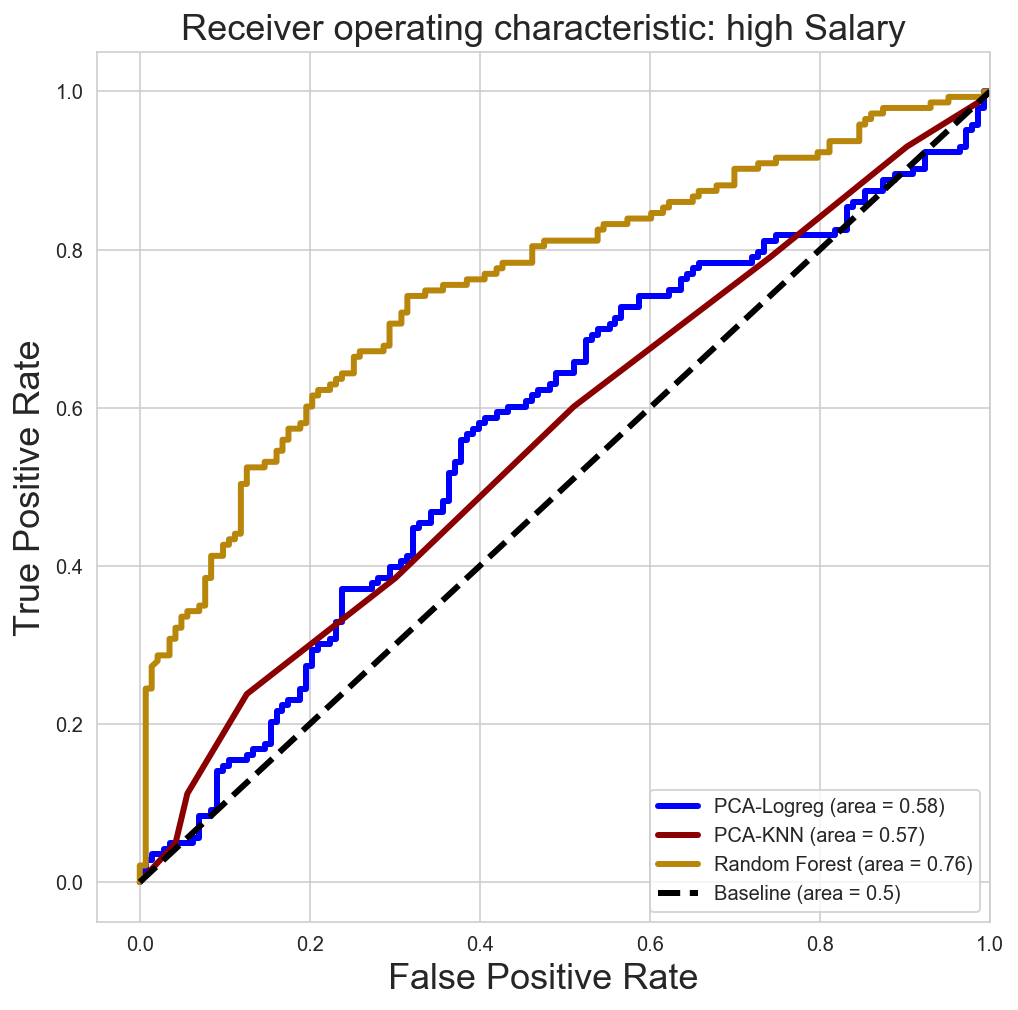

In [72]:
# Plot the ROC_AUC

plt.figure(figsize=[8,8])
# logistic regression roc_auc
plt.plot(lr_fpr, lr_tpr, label='PCA-Logreg (area = %0.2f)' % lr_roc_auc,
         linewidth=3, color = 'blue')
# KNN roc_auc
plt.plot(knn_fpr, knn_tpr, label='PCA-KNN (area = %0.2f)' % knn_roc_auc, 
         linewidth=3, color='darkred')
# Random Forest roc_auc
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc, 
         linewidth=3, color='darkgoldenrod')

plt.plot([0, 1], [0, 1], 'k--', linewidth=3, label='Baseline (area = 0.5)')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: high Salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 4. QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

### 4.0 What distinguish data scientists from other data jobs?

In [73]:
# Setup the Predictors and target
# Predictors: 'location','employment_type','seniority','job_categories','details' 
# target : Data_Scientist/Not Data_Scientist
# Note: Through EDA, it's observed that range of monthly_salary for a data scientist
# is hugh. Then we exclue the  Monthly_Salary here.

# One-hot encoding for predictors of categorical types
X_dummy = pd.get_dummies(jobs[['location','employment_type','seniority','job_categories']],
                                drop_first = True)

X = pd.concat([X_dummy, jobs[['details']]], axis=1)

y = np.where(jobs['title']=='Data Scientist',1,0)

In [74]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 8,
                                                    stratify =y)

In [75]:
# Transforming X_train
# Convert the 'details' feature to word tokens, ignore words 
# that only appeared once
cvec = CountVectorizer(stop_words='english', min_df=2, )
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['details']).todense(), 
                            columns=cvec.get_feature_names())

In [76]:
# Concatenate X_train_cvec and with remaining features of X_train
X_train_trf = X_train.copy().reset_index(drop = True)
X_train_trf.drop(['details'],axis =1, inplace=True)
X_train_trf = pd.concat([X_train_trf, X_train_cvec], axis=1)

In [77]:
# Do the same transformation for X_test
# Vectorise the 'details' feature
X_test_cvec = pd.DataFrame(cvec.transform(X_test['details']).todense(), 
                            columns=cvec.get_feature_names())

# Concatenate X_train_cvec and with remaining features of X_train 
X_test_trf = X_test.copy().reset_index(drop = True)
X_test_trf.drop(['details'],axis =1, inplace=True)
X_test_trf = pd.concat([X_test_trf, X_test_cvec], axis=1)

In [78]:
X_train_trf.shape

(666, 5908)

In [79]:
X_test_trf.shape

(286, 5908)

In [80]:
# Top 20 frequent words used in the job description/job requirements 
# in the training set
X_train_cvec.sum(axis=0).sort_values(ascending=False)[:20]

data           3610
experience     2043
business       1249
work           1112
skills         1070
team           1024
management      863
knowledge       798
research        728
development     682
strong          665
support         659
design          608
analysis        603
ability         583
working         561
project         537
analytics       532
good            531
years           518
dtype: int64

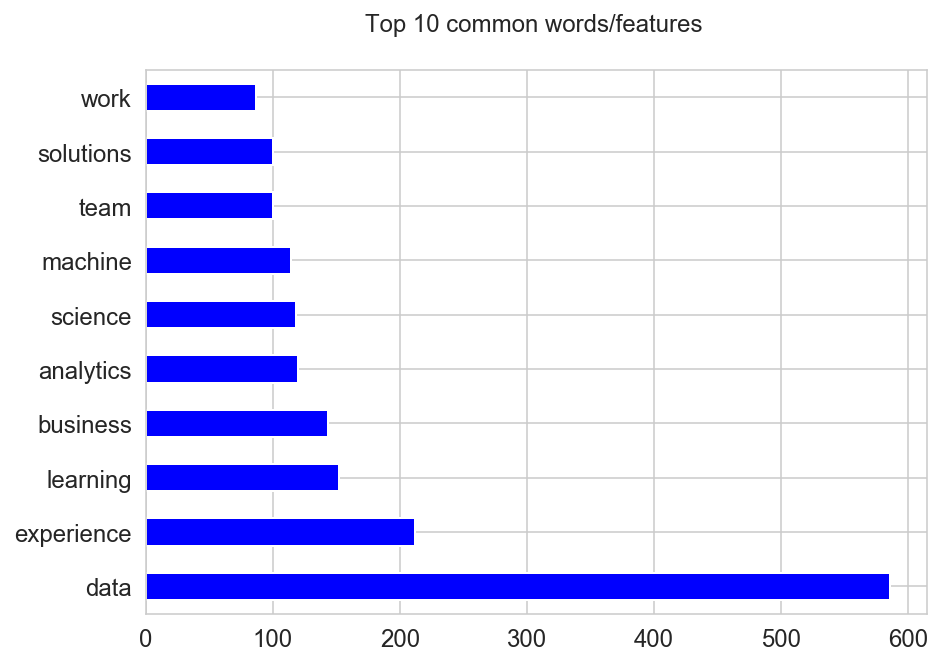

In [81]:
# Let's find out the features or words that most describe and least describe the requirements for 
# a Data Scientist:
# 
word_count = X_train_trf[y_train==1].sum(axis=0)

word_count.sort_values(ascending =False).head(10).plot(kind='barh',colormap='winter', figsize=(7,5))
plt.title('Top 10 common words/features \n', size=12)
plt.yticks(size=12)
plt.xticks(size=12)
plt.show()

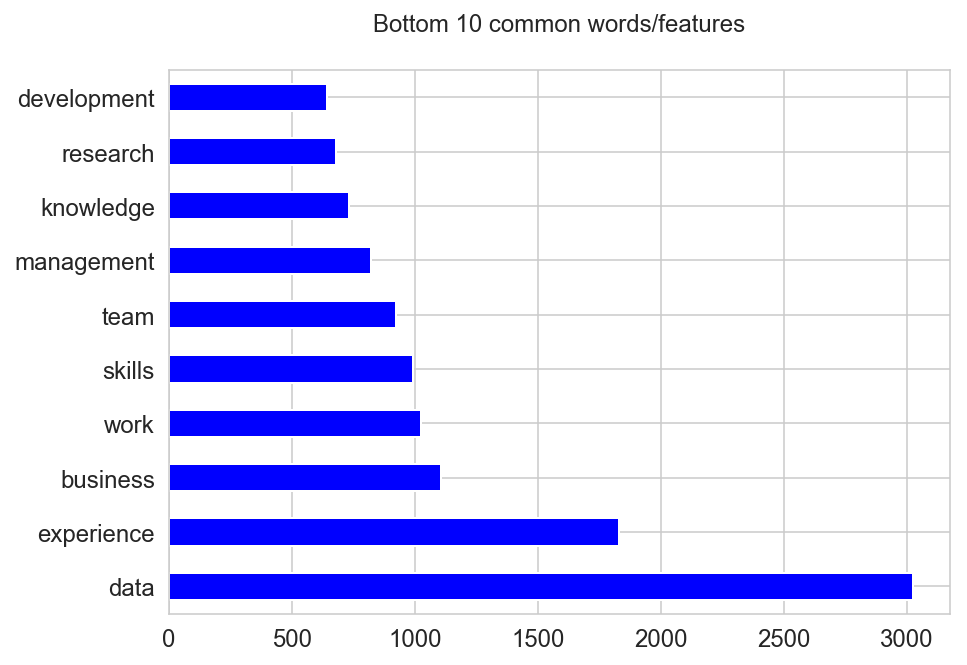

In [82]:
word_count = X_train_trf[y_train==0].sum(axis=0)

word_count.sort_values(ascending =False).head(10).plot(kind='barh',colormap='winter', figsize=(7,5))
plt.title('Bottom 10 common words/features\n', size=12)
plt.yticks(size=12)
plt.xticks(size=12)
plt.show()

In [83]:
# We see that -business, experience and data are common  
# requirements for Data Scientist and non Data Scientist.
# However, words such as 'analytics, science, machine, learning
# (interpreted as machine learning) are more prominent for 
# Data Science work scope.

In [84]:
print('Naive Bayes Multi-nomial:')
print('*' * 60)
nb = MultinomialNB()

# using a 10-fold cross-val
nb_scores = cross_val_score(nb, X_train_trf, y_train, cv=10)
nb_mean = np.mean(nb_scores)
nb_std = np.std(nb_scores)
print('Cross-Val Mean: {}'.format(nb_mean))
print('Cross-Val Std: {}'.format(nb_std))

nb_Model= nb.fit(X_train_trf,y_train)

yhat = nb.predict(X_test_trf)
nb_yhat_pp = nb.predict_proba(X_test_trf)

# Accuracy:
base_acc = max(np.mean(y_test), 1-np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

nb_recall = recall_score(y_test, yhat)
nb_precision = precision_score(y_test, yhat)
nb_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(nb_precision))
print('Recall: {}'.format(nb_recall))
print('roc_auc: {}'.format(nb_auc_score))

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_yhat_pp[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

Naive Bayes Multi-nomial:
************************************************************
Cross-Val Mean: 0.9384427512785722
Cross-Val Std: 0.022805482341587625
Baseline Accuracy: 0.9125874125874126
Model Accuracy: 0.9335664335664335

Precision: 0.59375
Recall: 0.76
roc_auc: 0.855095785440613


In [85]:
# Confusion Matrix
print('Naive Bayes Multi-nomial:')
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['Others', 'Data Scientist'],
                         columns=['predicted Others','predicted Data Scientist'])
confusion


Naive Bayes Multi-nomial:


,predicted Others,predicted Data Scientist
Others,248,13
Data Scientist,6,19


In [86]:
# Classification Report
print('Naive Bayes Multi-nomial:')
print(classification_report(y_test, yhat))

Naive Bayes Multi-nomial:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       261
           1       0.59      0.76      0.67        25

   micro avg       0.93      0.93      0.93       286
   macro avg       0.79      0.86      0.81       286
weighted avg       0.94      0.93      0.94       286



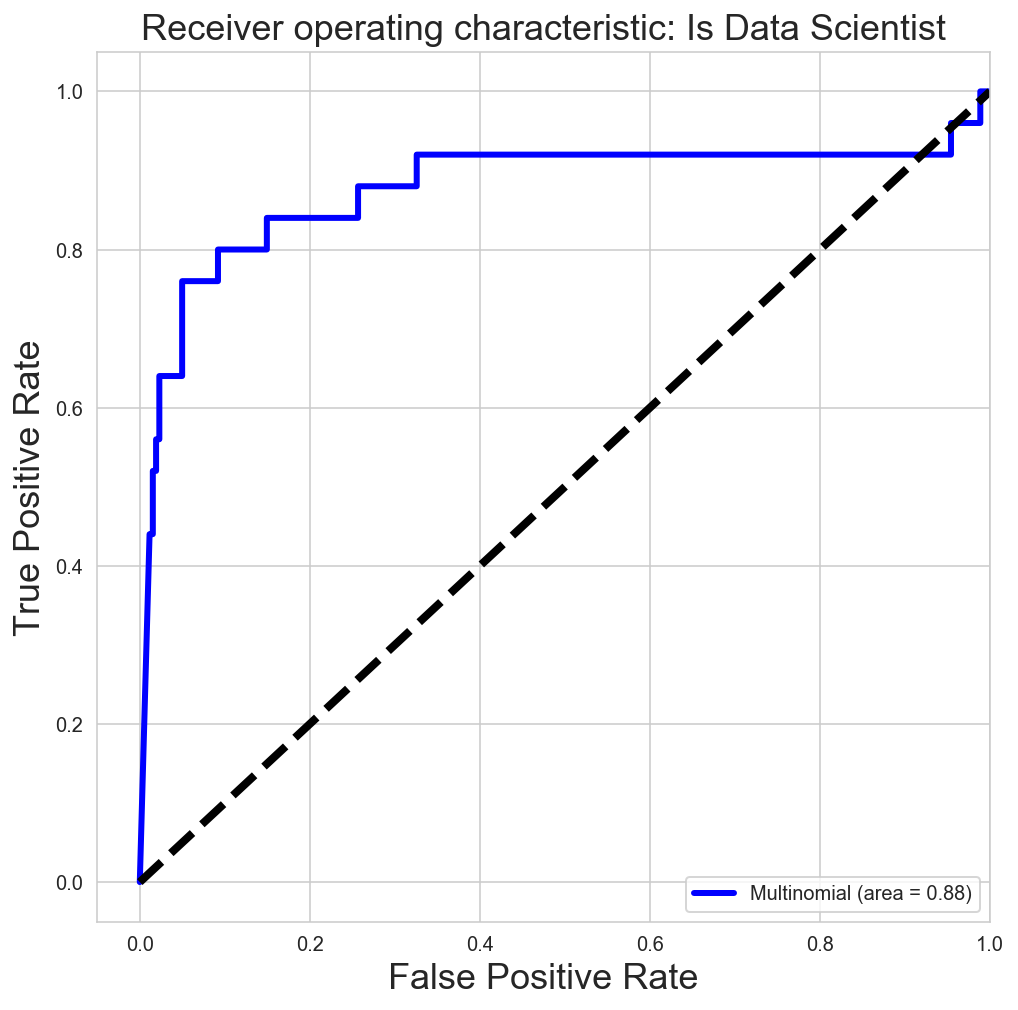

In [87]:
# Plot the ROC_AUC
plt.figure(figsize=[8,8])
# Naive Bayes Multinomial roc_auc
plt.plot(nb_fpr, nb_tpr, label='Multinomial (area = %0.2f)' % nb_roc_auc, linewidth=3, color ='blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Is Data Scientist', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [88]:
data_science = np.exp(nb.feature_log_prob_[1])
non_data_science = np.exp(nb.feature_log_prob_[0])

# Make a dataframe with the probabilities and features
feat_probs = pd.DataFrame({'Data Scientist':data_science, 'Others':non_data_science, 'feature':X_train_trf.columns.values})
feat_probs['Data Science Diff'] = feat_probs['Data Scientist'] - feat_probs['Others']

feat_probs.sort_values('Data Science Diff', ascending=False, inplace=True)
feat_probs.head(10)

# The top features/description that differentiate a Data Scientist from a 
# non-Data Scientist are as follows:

,Data Scientist,Others,feature,Data Science Diff
1521,0.031042,0.024192,data,0.006850
3139,0.008091,0.001743,learning,0.006348
3266,0.006081,0.001128,machine,0.004954
4746,0.006293,0.002711,science,0.003582
459,0.006399,0.003303,analytics,0.003096
3501,0.004019,0.001424,models,0.002596
5123,0.003490,0.000904,statistical,0.002587
3471,0.002538,0.000256,mining,0.002282
4997,0.005341,0.003175,solutions,0.002166
5345,0.003014,0.000960,techniques,0.002055


In [89]:
Data_science_class = np.exp(nb.feature_log_prob_[1])
Other_class = np.exp(nb.feature_log_prob_[0])

# # Make a dataframe with the probabilities and features
# feat_probs = pd.DataFrame({'Data Scientist':Data_science_class, 'Others':Other_class, 'feature':X_train_trf.columns.values})
# feat_probs['Data Science Diff'] = feat_probs['Data Scientist'] - feat_probs['Others']

# feat_probs.sort_values('Data Science Diff', ascending=False, inplace=True)
# feat_probs.head(10)
# len(Data_science_class)
# len(Other_class)
len(X_train_trf.columns.values)

5908

### 4.2 What features are important for distinguishing junior vs. senior positions?

#### 4.2.1 Classify by seniority multiclass

In [90]:
jobs['seniority'].value_counts()

Professional         285
Executive            221
Senior Executive     115
Non-executive         93
Manager               77
Junior Executive      47
Fresh/entry level     45
Middle Management     39
Senior Management     30
Name: seniority, dtype: int64

In [91]:
# Setup the Predictors and target
# Predictors: 'title','employment_type','job_categories','details'
# target : 'seniority'

# One-hot encoding for predictors of categorical types
X_dummy = pd.get_dummies(jobs[['title','employment_type','job_categories']],
                                drop_first = True)

X = pd.concat([X_dummy, jobs[['details']]], axis=1)

y = jobs['seniority']

In [92]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 8,
                                                    stratify =y)

In [93]:
# Transforming X_train
# Convert the 'details' feature to word tokens, ignore words 
# that only appeared once
cvec = CountVectorizer(stop_words='english', min_df=2, )
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['details']).todense(), 
                            columns=cvec.get_feature_names())

In [94]:
# Concatenate X_train_cvec and with remaining features of X_train
X_train_trf = X_train.copy().reset_index(drop = True)
X_train_trf.drop(['details'],axis =1, inplace=True)
X_train_trf = pd.concat([X_train_trf, X_train_cvec], axis=1)

In [95]:
# Do the same transformation for X_test
# Vectorise the 'details' feature
X_test_cvec = pd.DataFrame(cvec.transform(X_test['details']).todense(), 
                            columns=cvec.get_feature_names())

# Concatenate X_train_cvec and with remaining features of X_train 
X_test_trf = X_test.copy().reset_index(drop = True)
X_test_trf.drop(['details'],axis =1, inplace=True)
X_test_trf = pd.concat([X_test_trf, X_test_cvec], axis=1)

In [96]:
X_train_trf.shape

(666, 5817)

In [97]:
X_test_trf.shape

(286, 5817)

In [98]:
count = y_test.value_counts().head(1)

In [99]:
print('Naive Bayes Multi-nomial:')
print('*' * 60)
nb_sen = MultinomialNB()
nb_sen_Model = nb_sen.fit(X_train_trf,y_train)

nb_sen_yhat = nb_sen.predict(X_test_trf)

# using a 10-fold cross-val
nb_sen_scores = cross_val_score(nb_sen, X_train_trf, y_train, cv=10)
nb_sen_mean = np.mean(nb_sen_scores)
nb_sen_std = np.std(nb_sen_scores)

print('Cross-Val Mean: {}'.format(nb_sen_mean))
print('Cross-Val Std: {}'.format(nb_sen_std))

# Accuracy:
base_acc = y_test.value_counts()[0]/y_test.value_counts().sum()
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, nb_sen_yhat)))


Naive Bayes Multi-nomial:
************************************************************
Cross-Val Mean: 0.4110405137343599
Cross-Val Std: 0.05632997193682083
Baseline Accuracy: 0.3006993006993007
Model Accuracy: 0.4230769230769231


In [100]:
# Classification Report
print('Naive Bayes Multi-nomial (Seniority Multi-class):')
print(classification_report(y_test, nb_sen_yhat))

Naive Bayes Multi-nomial (Seniority Multi-class):
                   precision    recall  f1-score   support

        Executive       0.37      0.55      0.44        66
Fresh/entry level       0.67      0.15      0.25        13
 Junior Executive       0.00      0.00      0.00        14
          Manager       0.35      0.26      0.30        23
Middle Management       1.00      0.25      0.40        12
    Non-executive       0.47      0.61      0.53        28
     Professional       0.46      0.56      0.51        86
 Senior Executive       0.30      0.17      0.22        35
Senior Management       0.60      0.33      0.43         9

        micro avg       0.42      0.42      0.42       286
        macro avg       0.47      0.32      0.34       286
     weighted avg       0.43      0.42      0.40       286



In [101]:
print('Confusion Matrix for Seniority Multi-Class: ')
print('*'*60)
# Stores confusion matrix for y test and y predictions.  
nb_conmat = confusion_matrix(y_test, nb_sen_yhat, labels=nb_sen.classes_)
# Converts np.matrix format matrix to a DataFrame and adds index and column names:
nb_conmat = pd.DataFrame(nb_conmat, columns=nb_sen.classes_, index=nb_sen.classes_)
nb_conmat

Confusion Matrix for Seniority Multi-Class: 
************************************************************


,Executive,Fresh/entry level,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management
Executive,36,0,1,0,0,5,19,5,0
Fresh/entry level,6,2,0,2,0,0,3,0,0
Junior Executive,9,1,0,0,0,0,4,0,0
Manager,9,0,0,6,0,0,4,4,0
Middle Management,2,0,0,2,3,0,5,0,0
Non-executive,3,0,0,0,0,17,8,0,0
Professional,16,0,0,4,0,14,48,4,0
Senior Executive,13,0,0,2,0,0,12,6,2
Senior Management,3,0,0,1,0,0,1,1,3


#### 4.2.2 Classify by Senior/Junior

In [102]:
# Define junior as :
junior = ['Fresh/entry level','Non-executive', 'Junior Executive','Executive']
# Define the rest as senior:
senior = [x for x in jobs['seniority'].value_counts().index if x not in junior]
senior

['Professional',
 'Senior Executive',
 'Manager',
 'Middle Management',
 'Senior Management']

In [103]:
# Setup the Predictors and target
# This time, we will just use the details-job requirements and job description to 
# predict if the listing is for a senior or junior position.
# Predictors: 'details'
# target : senior/not senior

X = jobs[['details']]

# create a new target, senior =1, junior =0
y = jobs['seniority'].map(lambda x : 1 if x in senior else 0)

In [104]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 8,
                                                    stratify =y)

In [105]:
# Transforming X_train
# Convert the 'details' feature to word tokens, ignore words 
# that only appeared once
cvec = CountVectorizer(stop_words='english', min_df=2 )
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['details']).todense(), 
                            columns=cvec.get_feature_names())

In [106]:
# Do the same transformation for X_test
# Vectorise the 'details' feature
X_test_cvec = pd.DataFrame(cvec.transform(X_test['details']).todense(), 
                            columns=cvec.get_feature_names())

In [107]:
X_train_cvec.shape

(666, 5779)

In [108]:
X_test_cvec.shape

(286, 5779)

In [109]:
# logistic classifier
print('Logistic Regression (Seniority):')
print('*' * 60)
lr_sen = LogisticRegression(solver = 'liblinear')

# using a 10-fold cross-val
lr_sen_scores = cross_val_score(lr_sen, X_train_cvec, y_train, cv=10)
lr_sen_mean = np.mean(lr_sen_scores)
lr_sen_std = np.std(lr_sen_scores)
print('Cross-Val Mean: {}'.format(lr_sen_mean))
print('Cross-Val Std: {}'.format(lr_sen_std))

lr_sen_Model = lr_sen.fit(X_train_cvec, y_train)

yhat = lr_sen.predict(X_test_cvec)
yhat_pp = lr_sen.predict_proba(X_test_cvec)

# Accuracy:
base_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

lr_sen_recall = recall_score(y_test, yhat)
lr_sen_precision = precision_score(y_test, yhat)
lr_sen_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(lr_sen_precision))
print('Recall: {}'.format(lr_sen_recall))
print('roc_auc: {}'.format(lr_sen_auc_score))

lr_sen_fpr, lr_sen_tpr, _ = roc_curve(y_test, yhat_pp[:,1])
lr_sen_roc_auc = auc(lr_sen_fpr, lr_sen_tpr)

Logistic Regression (Seniority):
************************************************************
Cross-Val Mean: 0.6441336100247426
Cross-Val Std: 0.044290179833991486
Baseline Accuracy: 0.5734265734265734
Model Accuracy: 0.6678321678321678

Precision: 0.6906077348066298
Recall: 0.7621951219512195
roc_auc: 0.6515893642542983


In [110]:
# Confusion Matrix
print('Logistic Regression (Seniority):')
conmat = np.array(confusion_matrix(y_test, yhat))
confusion = pd.DataFrame(conmat, index=['junior', 'senior'],
                         columns=['predicted junior','predicted senior'])
confusion

Logistic Regression (Seniority):


,predicted junior,predicted senior
junior,66,56
senior,39,125


In [111]:
# Classification Report
print('Logistic Regression (Seniority):')
print(classification_report(y_test, yhat))

Logistic Regression (Seniority):
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       122
           1       0.69      0.76      0.72       164

   micro avg       0.67      0.67      0.67       286
   macro avg       0.66      0.65      0.65       286
weighted avg       0.66      0.67      0.66       286



In [112]:
'''
rf_params = {
    'max_depth':range(5,20),
    'n_estimators':range(5,20),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestClassifier(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring='roc_auc', 
                      n_jobs=-1)

rf_gs.fit(X_train_cvec, y_train)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


# best parameters: {'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 19}
# best train score: 0.7136358846885164
'''


'\nrf_params = {\n    \'max_depth\':range(5,20),\n    \'n_estimators\':range(5,20),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestClassifier(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=\'roc_auc\', \n                      n_jobs=-1)\n\nrf_gs.fit(X_train_cvec, y_train)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\n# best parameters: {\'max_depth\': 17, \'min_samples_split\': 17, \'n_estimators\': 19}\n# best train score: 0.7136358846885164\n'

In [113]:
print('Random Forest (seniority):')
print('*' * 60)
rfc_sen = RandomForestClassifier( max_depth= 17, min_samples_split= 17, n_estimators = 19,random_state=620)

rfc_sen_Model = rfc_sen.fit(X_train_cvec,y_train)
yhat = rfc_sen.predict(X_test_cvec)
yhat_pp = rfc_sen.predict_proba(X_test_cvec)

# using a 10-fold cross-val
rfc_sen_scores = cross_val_score(rfc_sen, X_train_cvec, y_train, cv=10)
rfc_sen_mean = np.mean(rfc_sen_scores)
rfc_sen_std = np.std(rfc_sen_scores)

print('Cross-Val Mean: {}'.format(rfc_sen_mean))
print('Cross-Val Std: {}'.format(rfc_sen_std))

# Accuracy:
base_acc = max(np.mean(y_test), 1 - np.mean(y_test))
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))
print("")

rfc_sen_recall = recall_score(y_test, yhat)
rfc_sen_precision = precision_score(y_test, yhat)
rfc_sen_auc_score = roc_auc_score(y_test, yhat)

print('Precision: {}'.format(rfc_sen_precision))
print('Recall: {}'.format(rfc_sen_recall))
print('roc_auc: {}'.format(rfc_sen_auc_score))

rfc_sen_fpr, rfc_sen_tpr, _ = roc_curve(y_test, yhat_pp[:,1])
rfc_sen_roc_auc = auc(rfc_sen_fpr, rfc_sen_tpr)

Random Forest (seniority):
************************************************************
Cross-Val Mean: 0.6427740974273021
Cross-Val Std: 0.04579859288624147
Baseline Accuracy: 0.5734265734265734
Model Accuracy: 0.6538461538461539

Precision: 0.6419213973799127
Recall: 0.8963414634146342
roc_auc: 0.6121051579368253


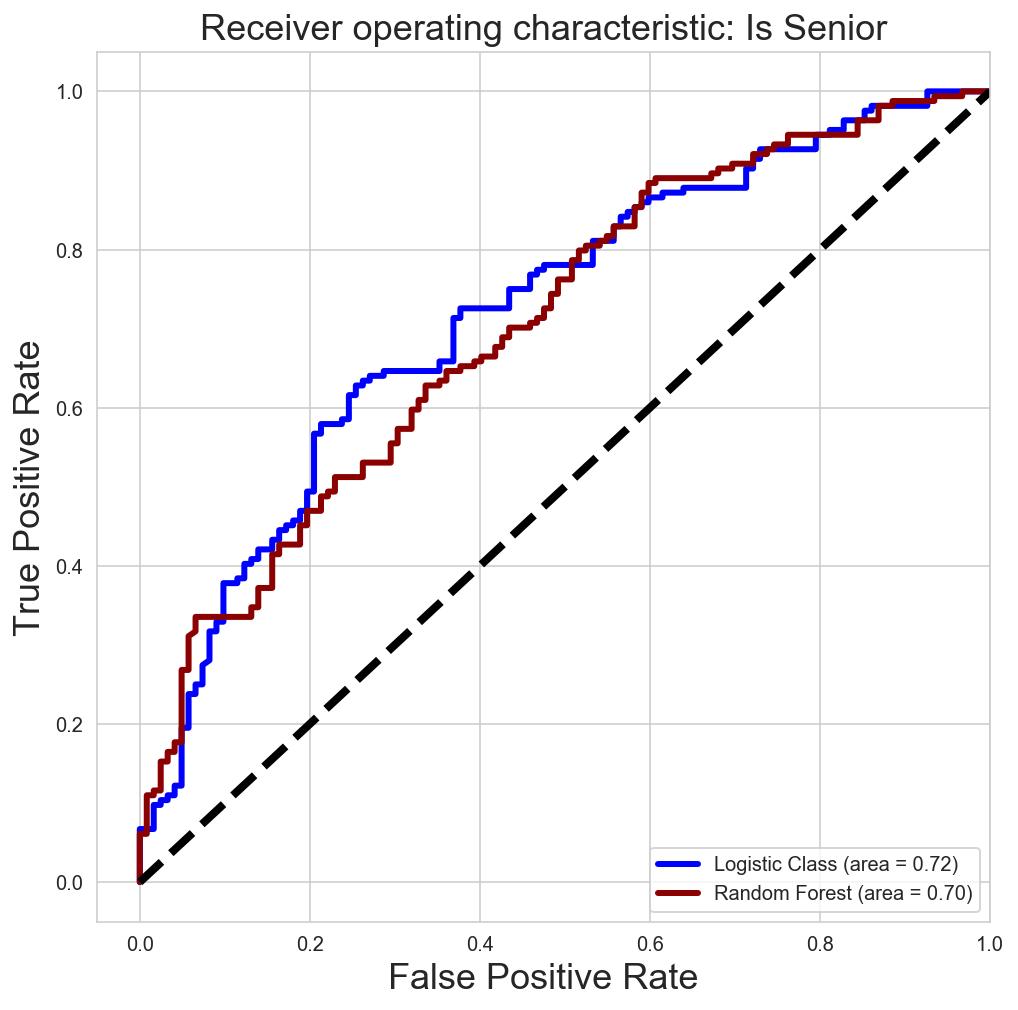

In [114]:
# Plot the ROC_AUC
plt.figure(figsize=[8,8])
# Logistic regression (seniority) roc_auc
plt.plot(lr_sen_fpr, lr_sen_tpr, label='Logistic Class (area = %0.2f)' % lr_sen_roc_auc, linewidth=3, color ='blue')
# Random Forest (seniority) roc_auc
plt.plot(rfc_sen_fpr, rfc_sen_tpr, label='Random Forest (area = %0.2f)' % rfc_sen_roc_auc, 
         linewidth=3, color='darkred')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Is Senior', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [115]:
# From the Random Forest Model:
# The top 20 features that differentiate a senior post from a junior post are as follows
features = pd.Series(data=rfc_sen.feature_importances_, index=X_train_cvec.columns.values).sort_values(ascending=False)[:20]
features

understanding    0.010373
delivery         0.007901
notice           0.007199
data             0.007113
amended          0.007110
developed        0.006869
exhaustive       0.006794
design           0.006685
quality          0.006636
experience       0.006612
eligibility      0.006556
complex          0.006519
individuals      0.006040
team             0.005852
drive            0.005848
ethics           0.005842
functional       0.005817
excel            0.005810
13c6338          0.005710
deliver          0.005696
dtype: float64

### Executive Summary

1. Web Scrapping

The data source is from published job listings. See https://www.mycareersfuture.sg

What is useful? Only search for related job listings by keying in relevant search keys, otherwise you will end up with lots of irrelevant data.

2. EDA

As the 'Data Science' industry is new, the job titles across the various 
sectors/companies are non-uniform. A bit of grouping/cleaning is required
in order to obtain sensible modelling results.

3. Question 1: Factors that impact salary

I used 3 models to predict the classification (high salary versus low salary)
- Logistic Regression (with PCA)
- KNN (with PCA)
- Random Forest (without PCA)

PCA was used to reduce the dimensionality from 5850 features to 200 tranformed 
dimensions. In doing so, we could still retain about 84% of the variance.
Comparing the roc_auc and precision of the 3 models, 
Logistic Regression: roc_auc: 0.59, precision : 0.596
                KNN: roc_auc: 0.54, precision : 0.561
      Random Forest: roc_auc: 0.699, precision : 0.70
 
This expected since unlike Logistic Regression and KNN, we already started 
with a loss of 16% in the data.

Findings:
Top 10 factors affecting high pay are:
understanding                          0.018019
employment_type_Contract, Full Time    0.011690
spark                                  0.010641
best                                   0.008903
solutions                              0.008524
technical                              0.007924
big                                    0.007856
teams                                  0.007013
agile                                  0.006879
innovation                             0.006761

It makes sense as a high paying job would require the applicant to have 
a good understanding of the domain, able to lead teams, provide innovative
and technical solutions and probably require agile development, have a
hand in Apache spark and to deal with big data. The only strange feature
is "contract, full time' but not 'permanent,full time' though.

In [ ]:
4. Question 2a: What distinguish data scientists from other data jobs?

Model used:Naive Bayes Multinomial 
Findings: The top 10 differentiating factors are:
        1. data
        2. learning
        3. machine
        4. science
        5. analytics
        6. models
        7. statistical
        8. mining
        9. solutions
        10. techniques
These factors are definitely appropriate for what it takes to be a Data Scientist

5. Question 2b: What features are important for distinguishing junior vs. senior positions?

In [ ]:
Model used:Logistic Regression and Random Forest 
Findings: Senior positions are expected in the following areas:
        1. understanding
        2. delivery
        3. notice
        4. data
        5. amended
        6. developed
        7. exhaustive
        8. design
        9. quality
        10. experience


### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [ ]:
# Due to lack of time to complete this project.
# The idea here is to raise the threshold in the labelling of high salary
# so that we could raise the Precision value (TP/(TP + FP))